<a href="https://colab.research.google.com/github/davidcpage/cifar10-fast/blob/master/batch_norm_post.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Optional: running on GCP

You can run this notebook using a free Colab GPU instance (Tesla T4) but some computations may be slow and/or run out of memory. 
If you have a GCP account and want to  use a faster V100 GPU you can follow the instructions [here](https://blog.kovalevskyi.com/gce-deeplearning-images-as-a-backend-for-google-colaboratory-bc4903d24947) to use that as an alternative Colab backend. I recommend giving it a try if you have a GCP account and haven't used this feature before. Don't forget to shut down the GCP instance (not just the Colab notebook) once you've finished!

FWIW, I use the following (preemptible) instance type:

```
export IMAGE_FAMILY="pytorch-latest-cu100"
export ZONE="europe-west4-a"
export INSTANCE_NAME="pytorch-colab-backend"

gcloud compute instances create $INSTANCE_NAME \
  --zone $ZONE \
  --machine-type n1-standard-4 \
  --accelerator type=nvidia-tesla-v100,count=1 \
  --image-family $IMAGE_FAMILY \
  --image-project=deeplearning-platform-release \
  --metadata install-nvidia-driver=True \
  --maintenance-policy TERMINATE \
  --preemptible 
  ```


On GCP you will need to install altair for plotting. This is pre-installed on Colab instances.

In [1]:
#GCP only
!python -m pip install -q vega altair

You should consider upgrading via the '/home/ubuntu/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


You can check the details of your setup (free Colab GPU or V100 on GCP) with this nice utility from fastai:

In [2]:
from fastai.utils.show_install import show_install 
show_install()



```text
=== Software === 
python        : 3.6.10
fastai        : 1.0.61
fastprogress  : 0.2.4
torch         : 1.6.0
nvidia driver : 440.33
torch cuda    : 10.2 / is available
torch cudnn   : 7605 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16160MB | Tesla V100-SXM2-16GB

=== Environment === 
platform      : Linux-5.3.0-1019-aws-x86_64-with-debian-buster-sid
distro        : Ubuntu 18.04 bionic
conda env     : pytorch_p36
python        : /home/ubuntu/anaconda3/envs/pytorch_p36/bin/python
sys.path      : /home/ubuntu/src/cntk/bindings/python
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python36.zip
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/lib-dynload

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/bask-0.6.0-py3.6.egg
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/emcee-3.0.

### Setup

In [3]:
#@title Lib [RUN ME]

#####################
## CORE
#####################

import inspect

#####################
## dict utils
#####################

union = lambda *dicts: {k: v for d in dicts for (k, v) in d.items()}

make_tuple = lambda path: (path,) if isinstance(path, str) else path

def path_iter(nested_dict, pfx=()):
    for name, val in nested_dict.items():
        if isinstance(val, dict): yield from path_iter(val, pfx+make_tuple(name))
        else: yield (pfx+make_tuple(name), val)  

#####################
## graph building
#####################

def graph(net):
    net = dict(path_iter(net))
    nodes = {path: (v[0] if type(v) is tuple else v) for path, v in net.items()} 
    default_inputs = [[('input',)]]+[[k] for k in net.keys()]
    resolve_path = lambda net, path, pfx: pfx+path if (pfx+path in net or not pfx) else resolve_path(net, path, pfx[:-1])
    inputs = {path: [resolve_path(net, make_tuple(k), path[:-1]) for k in v[1]] if type(v) is tuple else default for (path, v), default in zip(net.items(), default_inputs)}
    return nodes, inputs

identity = lambda x: x

def _get_first(mapping, keys, default):
    for key in keys:
        if key in mapping:
            return mapping[key]
    return default
        
def map_nodes(nodes, mapping):
    return {path: _get_first(mapping, (path,)+inspect.getmro(type(node)), identity)(node) for path, node in nodes.items()}  

#####################
## network visualisation (requires pydot)
#####################

class ColorMap(dict):
    palette = (
        'bebada,ffffb3,fb8072,8dd3c7,80b1d3,fdb462,b3de69,fccde5,bc80bd,ccebc5,ffed6f,1f78b4,33a02c,e31a1c,ff7f00,'
        '4dddf8,e66493,b07b87,4e90e3,dea05e,d0c281,f0e189,e9e8b1,e0eb71,bbd2a4,6ed641,57eb9c,3ca4d4,92d5e7,b15928'
    ).split(',')
    def __missing__(self, key):
        self[key] = self.palette[len(self) % len(self.palette)]
        return self[key]

def make_pydot(nodes, edges, direction='LR', sep='_', **kwargs):
    from pydot import Dot, Cluster, Node, Edge
    parent = lambda path: path[:-1]
    class Subgraphs(dict):
        def __missing__(self, path):
            subgraph = Cluster(sep.join(path), label=path[-1], style='rounded, filled', fillcolor='#77777744')
            self[parent(path)].add_subgraph(subgraph)
            return subgraph
    g = Dot(rankdir=direction, directed=True, **kwargs)
    g.set_node_defaults(
        shape='box', style='rounded, filled', fillcolor='#ffffff')
    subgraphs = Subgraphs({(): g})
    for path, attr in nodes:
        subgraphs[parent(path)].add_node(
            Node(name=sep.join(path), label=path[-1], **attr))
    for src, dst, attr in edges:
        g.add_edge(Edge(sep.join(src), sep.join(dst), **attr))
    return g

class DotGraph():
    colors = ColorMap()   
    def __init__(self, nodes, inputs, size=15, direction='LR'):
        get_params = lambda mod: {p.name: getattr(mod, p.name, '?') for p in inspect.signature(type(mod)).parameters.values()}
        self.nodes = [(k, {
            'tooltip': '%s %.1000r' % (type(n).__name__, get_params(n)), 
            'fillcolor': '#'+self.colors[type(n)],
        }) for k, n in nodes.items()] 
        self.edges = [(src, k, {}) for (k, i) in inputs.items() for src in i]
        self.size, self.direction = size, direction

    def dot_graph(self, **kwargs):
        return make_pydot(self.nodes, self.edges, size=self.size, 
                            direction=self.direction, **kwargs)

    def svg(self, **kwargs):
        return self.dot_graph(**kwargs).create(format='svg').decode('utf-8')

    try:
        import pydot
        def _repr_svg_(self):
            return self.svg()
    except ImportError:
        def __repr__(self):
            return 'pydot is needed for network visualisation'

#####################
## NODE TYPES
##################### 

from collections import namedtuple
from functools import partial

Conv = namedtuple('Conv', ['in_channels', 'out_channels', 'kernel_size', 'stride', 'padding'])
Normalise = namedtuple('Normalise', ['num_features'])
Activation = namedtuple('Activation', [])
Pool = namedtuple('Pool', ['kernel_size'])
Scale = namedtuple('Scale', [])
class Flatten(namedtuple('Flatten', [])):
    def __call__(self, x): 
        return flatten(x)
    
class Add(namedtuple('Add', [])):
    def __call__(self, x, y): return x + y 
    
class AddWeighted(namedtuple('AddWeighted', ['wx', 'wy'])):
    def __call__(self, x, y): return self.wx*x + self.wy*y 
    
def _convert_node(func, node, **kwargs): 
    return func(**union(node._asdict(), kwargs))
convert_node = lambda func, **kwargs: partial(_convert_node, func, **kwargs)
        
#####################
## TORCH 
##################### 

import numpy as np
import torch
from torch import nn
from collections import namedtuple
import copy

torch.backends.cudnn.benchmark = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#####################
## Layers
##################### 

class Network(nn.Module):
    def __init__(self, nodes, inputs):
        super().__init__()
        self._nodes = nodes
        self._inputs = {'_'. join(path): ['_'.join(x) for x in xs] for path, xs in inputs.items()}
        for path, node in nodes.items(): 
            setattr(self, '_'.join(path), node)
    
    def forward(self, inputs):
        outputs = dict(inputs)
        for n, i in self._inputs.items():
            outputs[n] = getattr(self, n)(*[outputs[x] for x in i])
        return outputs

def batch_norm(num_features, type_, weight, bias, weight_freeze, bias_freeze, **kwargs):
    bn = type_(num_features=num_features, **kwargs)
    bn.weight.data.fill_(weight)
    bn.bias.data.fill_(bias)
    bn.weight.requires_grad = not weight_freeze
    bn.bias.requires_grad = not bias_freeze
    return bn
  
def conv(in_channels, out_channels, kernel_size, type_=nn.Conv2d, weight_scale = np.sqrt(6), **kwargs):
  layer = type_(in_channels, out_channels, kernel_size, **kwargs)
  # Pytorch weight init differs from He-et-al by a factor 
  # of sqrt(6), so we fix this here.
  layer.weight.data *= weight_scale
  return layer

def linear(in_features, out_features, bias=True, weight_scale = np.sqrt(6)):
  layer = nn.Linear(in_features, out_features, bias=bias)
  # Pytorch weight init differs from He-et-al by a factor 
  # of sqrt(6), so we fix this here.
  layer.weight.data *= weight_scale 
  return layer

class Mul(nn.Module):
    def __init__(self, weight):
        super().__init__()
        self.weight = weight
    def __call__(self, x): 
        return x*self.weight

class Identity(nn.Module):
    def forward(self, x):
        return x

# Losses
class CrossEntropyLoss(namedtuple('CrossEntropyLoss', [])):
    def __call__(self, log_probs, target):
        return torch.nn.functional.nll_loss(log_probs, target, reduction='none')
    
class KLLoss(namedtuple('KLLoss', [])):        
    def __call__(self, log_probs):
        return -log_probs.mean(dim=1)

class Correct(namedtuple('Correct', [])):
    def __call__(self, classifier, target):
        return classifier.max(dim = 1)[1] == target

class LogSoftmax(namedtuple('LogSoftmax', ['dim'])):
    def __call__(self, x):
        return torch.nn.functional.log_softmax(x, self.dim, _stacklevel=5)


fp16 = partial(map_nodes, mapping={nn.Module: lambda m: m.half(), nn.BatchNorm2d: identity})

#####################
## Compat
##################### 

def flatten(x):
    return x.view(x.size(0), x.size(1))

def to_numpy(x):
    if isinstance(x, torch.Tensor):
      return x.detach().cpu().numpy()  
    return x
  
trainable_params = lambda model: {k:p for k,p in model.named_parameters() if p.requires_grad}

to_vec = lambda list_of_tensors: torch.cat([x.reshape(-1) for x in list_of_tensors])

def param_dict_from_vec(vec, template_params):
  end_indices = list(np.cumsum([p.numel() for p in template_params.values()]))
  return {k: vec[x:y].reshape(p.shape) for x,y, (k,p) in zip([0]+end_indices, end_indices, template_params.items())}

def perturbed_model(model, vec):
  p = param_dict_from_vec(vec, trainable_params(model))
  delta_state_dict = {k: v+torch.tensor(p[k], device=device, dtype=v.dtype) if k in p else v.clone() 
          for k,v in model.state_dict().items()}
  cloned_model = copy.deepcopy(model)
  cloned_model.load_state_dict(delta_state_dict)
  return cloned_model

def compute_grad(model, batches, outputs, vec=None):
  return sum(to_vec(torch.autograd.grad(outputs(model, batch), trainable_params(model).values(), grad_outputs=vec, only_inputs=True)).to(dtype=torch.float)
      for batch in batches)/len(batches) #i believe sum(generator)/len is memory efficient but i haven't checked...

#####################
## Optimisers
##################### 

from functools import partial

def nesterov_update(w, dw, v, lr, weight_decay, momentum):
    dw.add_(weight_decay, w).mul_(-lr)
    v.mul_(momentum).add_(dw)
    w.add_(dw.add_(momentum, v))

norm = lambda x: torch.norm(x.reshape(x.size(0),-1).float(), dim=1)[:,None,None,None]

def LARS_update(w, dw, v, lr, weight_decay, momentum):
    nesterov_update(w, dw, v, lr*(norm(w)/(norm(dw)+1e-2)).to(w.dtype), weight_decay, momentum)

def zeros_like(weights):
    return [torch.zeros_like(w) for w in weights]

def optimiser(weights, param_schedule, update, state_init):
    weights = list(weights)
    return {'update': update, 'param_schedule': param_schedule, 'step_number': 0, 'weights': weights,  'state': state_init(weights)}

def opt_step(update, param_schedule, step_number, weights, state):
    step_number += 1
    param_values = {k: f(step_number) for k, f in param_schedule.items()}
    for w, v in zip(weights, state):
        if w.requires_grad:
            update(w.data, w.grad.data, v, **param_values)
    return {'update': update, 'param_schedule': param_schedule, 'step_number': step_number, 'weights': weights,  'state': state}

LARS = partial(optimiser, update=LARS_update, state_init=zeros_like)
SGD = partial(optimiser, update=nesterov_update, state_init=zeros_like)

def opt_steps(optimisers, **kw):
    return {'optimisers': [opt_step(**opt) for opt in optimisers]}
  
class PiecewiseLinear(namedtuple('PiecewiseLinear', ('knots', 'vals'))):
    def __call__(self, t):
        return np.interp([t], self.knots, self.vals)[0]
    def __mul__(self, other):
      return self._replace(vals=np.array(self.vals)*other)
    __rmul__ = __mul__
     
class Const(namedtuple('Const', ['val'])):
    def __call__(self, x):
        return self.val

#####################
## DATA
#####################    

import torchvision
from collections import namedtuple
from fastai.vision import ImageList, untar_data, URLs
from functools import lru_cache as cache

def imagelist2np(imagelist):
    return to_numpy(torch.cat([image.data.unsqueeze(0) for image in imagelist]))

@cache(None)
def cifar10():
    ## implementation using fastai dataset
    path = untar_data(URLs.CIFAR)
    data = ImageList.from_folder(path).split_by_folder(valid='test').label_from_folder()
    return {
        'train': {'data': transpose(imagelist2np(data.train.x), 'NCHW', 'NHWC'), 'labels': np.array(data.train.y.items)},
        'valid': {'data': transpose(imagelist2np(data.valid.x), 'NCHW', 'NHWC'), 'labels': np.array(data.valid.y.items)}
    }
    
class Batches():
    def __init__(self, dataset, batch_size, shuffle, set_random_choices=False, num_workers=0, drop_last=False, dtype=torch.float16):
        self.dataset = dataset
        self.batch_size = batch_size
        self.set_random_choices = set_random_choices
        self.dataloader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True, shuffle=shuffle, drop_last=drop_last
        )
        self.dtype=dtype
    
    def __iter__(self):
        if self.set_random_choices:
            self.dataset.set_random_choices() 
        return ({'input': x.to(device, dtype=self.dtype), 'target': y.to(device).long()} for (x,y) in self.dataloader)
    
    def __len__(self): 
        return len(self.dataloader)

#####################
## data preprocessing
#####################

cifar10_mean = (0.4914, 0.4822, 0.4465) # equals np.mean(cifar10()['train']['data'], axis=(0,1,2))
cifar10_std = (0.2471, 0.2435, 0.2616) # equals np.std(cifar10()['train']['data'], axis=(0,1,2))

def normalise(x, mean=cifar10_mean, std=cifar10_std):
    x, mean, std = [np.array(a, np.float32) for a in (x, mean, std)]
    x -= mean
    x *= 1.0/std
    return x

def pad(x, border=4):
    return np.pad(x, [(0, 0), (border, border), (border, border), (0, 0)], mode='reflect')

def transpose(x, source='NHWC', target='NCHW'):
    return x.transpose([source.index(d) for d in target]) 

#####################
## data augmentation
#####################

class Crop(namedtuple('Crop', ('h', 'w'))):
    def __call__(self, x, x0, y0):
        return x[:,y0:y0+self.h,x0:x0+self.w]

    def options(self, x_shape):
        C, H, W = x_shape
        return {'x0': range(W+1-self.w), 'y0': range(H+1-self.h)}
    
    def output_shape(self, x_shape):
        C, H, W = x_shape
        return (C, self.h, self.w)
    
class FlipLR(namedtuple('FlipLR', ())):
    def __call__(self, x, choice):
        return x[:, :, ::-1].copy() if choice else x 
        
    def options(self, x_shape):
        return {'choice': [True, False]}

class Cutout(namedtuple('Cutout', ('h', 'w'))):
    def __call__(self, x, x0, y0):
        x = x.copy()
        x[:,y0:y0+self.h,x0:x0+self.w].fill(0.0)
        return x

    def options(self, x_shape):
        C, H, W = x_shape
        return {'x0': range(W+1-self.w), 'y0': range(H+1-self.h)} 
    
    
class Transform():
    def __init__(self, dataset, transforms):
        self.dataset, self.transforms = dataset, transforms
        self.choices = None
        
    def __len__(self):
        return len(self.dataset)
           
    def __getitem__(self, index):
        data, labels = self.dataset[index]
        for choices, f in zip(self.choices, self.transforms):
            args = {k: v[index] for (k,v) in choices.items()}
            data = f(data, **args)
        return data, labels
    
    def set_random_choices(self):
        self.choices = []
        x_shape = self.dataset[0][0].shape
        N = len(self)
        for t in self.transforms:
            options = t.options(x_shape)
            x_shape = t.output_shape(x_shape) if hasattr(t, 'output_shape') else x_shape
            self.choices.append({k:np.random.choice(v, size=N) for (k,v) in options.items()})
        return self


#####################
## TRAINING
#####################
import time
from itertools import chain

class Timer():
    def __init__(self):
        self.times = [time.time()]
        self.total_time = 0.0

    def __call__(self, include_in_total=True):
        self.times.append(time.time())
        delta_t = self.times[-1] - self.times[-2]
        if include_in_total:
            self.total_time += delta_t
        return delta_t

class Table():
    def __init__(self, keys=None, log=None, report_every = 1, col_width=12, formats=None, title_format='{:>{w}s}', default_format='{:{w}}'):
        formats = formats or {float: '{:{w}.4f}', str: '{:>{w}s}'}
        self.keys = keys
        self.log = [] if log is None else log
        self.report_every = report_every
        typ = lambda v: float if isinstance(v, (float, np.float)) else type(v)
        self.format = lambda v, is_title=False: (title_format if is_title else formats.get(typ(v), default_format)).format(v, w=col_width)
    
    def append(self, data):
        self.log.append(data)
        data = {' '.join(p): v for p,v in path_iter(data)}
        self.keys = self.keys or data.keys()
        if len(self.log) is 1:
            print(*(self.format(k, True) for k in self.keys))
        if len(self.log) % self.report_every == 0:
            print(*(self.format(data[k]) for k in self.keys))         


def reduce(batches, state, steps):
    #state: is a dictionary
    #steps: are functions that take (batch, state)
    #and return a dictionary of updates to the state (or None)
    
    for batch in chain(batches, [None]): 
    #we send an extra batch=None at the end for steps that 
    #need to do some tidying-up (e.g. log_activations)
        for step in steps:
            updates = step(batch, state)
            if updates:
                for k,v in updates.items():
                    state[k] = v                  
    return state
  
#define keys in the state dict as constants
MODEL_KEY = 'model'
OPT_KEY = 'optimisers'
OUTPUT_KEY = 'output'
ACT_LOG_KEY = 'activation_log'

#step definitions
def forward(batch, state):
    if not batch: return
    return {OUTPUT_KEY: state[MODEL_KEY](batch)}
    
def backward(batch, state):
    state[MODEL_KEY].zero_grad()
    if not batch: return
    state[OUTPUT_KEY]['loss'].sum().backward()

def opt_steps(batch, state):
    if not batch: return
    return {OPT_KEY: [opt_step(**opt) for opt in state[OPT_KEY]]}

def log_activations(node_names):
    logs = {k: [] for k in node_names}
    def step(batch, state):
        if batch:
            for k in node_names:
                logs[k] = logs.get(k, [])
                logs[k].append(state[OUTPUT_KEY][k].detach()) #keep on GPU and collate at the end
        else:
            collate = lambda stats: to_numpy(torch.cat(stats)).astype(np.float)
            return {ACT_LOG_KEY: {k: collate(v) for k,v in logs.items()}}
    return step

def train(model, optimisers, epochs, train_batches, valid_batches, timer=None, table=None):
    table = table or Table()
    timer = timer or Timer()
    state = {MODEL_KEY: model, OPT_KEY: optimisers}
    
    for epoch in epochs:
        model.train(True)
        state = reduce(train_batches, state, [forward, log_activations(('loss', 'correct')), backward, opt_steps]) 
        train_stats = state[ACT_LOG_KEY]
        train_summary = {'time': timer(), 'loss': np.mean(train_stats['loss']), 'acc': np.mean(train_stats['correct'])}

        model.train(False)
        state = reduce(valid_batches, state, [forward, log_activations(('loss', 'correct'))]) 
        valid_stats = state[ACT_LOG_KEY]
        valid_summary = {'time': timer(), 'loss': np.mean(valid_stats['loss']), 'acc': np.mean(valid_stats['correct'])}
       
        table.append({'epoch': epoch+1, 'train': train_summary, 'valid': valid_summary, 'total time': timer.total_time})
        if np.isnan(np.mean(train_stats['loss'])): break
    return state[MODEL_KEY], state[OPT_KEY]

#####################
## NETWORKS
#####################
    
conv_block = lambda c_in, c_out: {
    'conv': Conv(in_channels=c_in, out_channels=c_out, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
    'norm': Normalise(c_out), 
    'act': Activation(),
}

conv_block_post = lambda c_in, c_out: {
    'conv': Conv(in_channels=c_in, out_channels=c_out, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
    'act': Activation(),
    'norm': Normalise(c_out),
}

residual = lambda c, conv_block: {
        'in': Identity(),
        'res1': conv_block(c, c),
        'res2': conv_block(c, c),
        'out': Identity(),
        'add': (Add(), ['in', 'out']),
}

def build_net(channels, extra_layers, res_layers, conv_block):      
    net = {
        'scale': Mul(1./np.sqrt(2)),
        'prep': conv_block(3, channels['prep']),
        'layer1': dict(conv_block(channels['prep'], channels['layer1']), pool=Pool(2)),
        'layer2': dict(conv_block(channels['layer1'], channels['layer2']), pool=Pool(2)),
        'layer3': dict(conv_block(channels['layer2'], channels['layer3']), pool=Pool(2)),
        'pool': Pool(4),
        'classifier': {
            'conv': Conv(in_channels=channels['layer3'], out_channels=10, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            'scale': Mul(0.125/np.sqrt(6)),
            'out': Flatten(),
        }
    }
    for layer in res_layers:
        net[layer]['residual'] = residual(channels[layer], conv_block)
    for layer in extra_layers:
        net[layer]['extra'] = conv_block(channels[layer], channels[layer]) 
        
    return net

def losses(alpha=None, beta=None):
    if alpha is None:
      return {
       'loss':  (nn.CrossEntropyLoss(reduction='none'), [('classifier','out'), ('target',)]),
       'correct': (Correct(), [('classifier','out'), ('target',)]),
      }
    return {
        'logp': (LogSoftmax(1), [('classifier','out')]),
        'KL':  (KLLoss(), [('logp',)]),
        'xent':  (CrossEntropyLoss(), [('logp',), ('target',)]),
        'loss': (AddWeighted(alpha, beta), [('xent',), ('KL',)]),
        'correct': (Correct(), [('classifier','out'), ('target',)]),
    }

mapping = {
    Conv: convert_node(conv, bias=False),
    Activation: convert_node(nn.ReLU),
    Pool: convert_node(nn.MaxPool2d),
    Normalise: convert_node(batch_norm, type_=nn.BatchNorm2d, weight=1.0, bias=0.0, weight_freeze=True, bias_freeze=True),
}

channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512}

nets = {
    'simple': build_net(channels, extra_layers=('layer1', 'layer2', 'layer3'), res_layers=(), conv_block=conv_block),
    'post': build_net(channels, extra_layers=('layer1', 'layer2', 'layer3'), res_layers=(), conv_block=conv_block_post),
    'full': build_net(channels, extra_layers=(), res_layers=('layer1', 'layer3'), conv_block=conv_block)
}

def build_model(net, overrides=(), losses=(), display_model=True):
    nodes, inputs = graph(union(net, dict(losses)))
    nodes = map_nodes(nodes, union(mapping, dict(overrides)))
    if display_model:
      display(DotGraph(nodes, inputs))
    return Network(fp16(nodes), inputs).to(device)
  
  
#####################
## PLOTTING
#####################

import altair as alt
alt.renderers.enable('colab')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import SVG

sns.set(style="whitegrid")

def hist(x,  ax, color=None):
  sns.distplot(x, hist=True, kde=False, color=color,
               bins=50,norm_hist=True, 
               hist_kws={'edgecolor':color}, ax=ax) 

kde = partial(sns.kdeplot, vertical=False, shade=True)

def channel_plot(layer_output, plot_type=kde, title=None, nchannels=10, xlim=(-7, 7), xticks=None, vline_height=0.33):
  data = to_numpy(layer_output.transpose(1,0))[:nchannels].reshape(nchannels, -1).astype(np.float32)
  def plot_func(ax, data, title, plot_type, nchannels, xlim, xticks, vline_height):
    for x, color in zip(data, sns.color_palette()):
      plot_type(x, ax=ax, color=color)
      if vline_height:
        ax.vlines([np.min(x), np.max(x)], 0, vline_height, color=color)
    ax.scatter(np.mean(data, axis=1), [-0.1*ax.get_ylim()[1]]*nchannels, marker='o', alpha=1, s=30, 
               color=sns.color_palette()[:nchannels])
    ax.set_xlim(xlim)
    if xlim or xticks:
      ax.set_xticks(xticks or [xlim[0],0,xlim[1]])
    ax.set_yticks([])
    ax.set_title(title)
    return ax
  return partial(plot_func, data=data, title=title, plot_type=plot_type, nchannels=nchannels, 
                 xlim=xlim, xticks=xticks, vline_height=vline_height)

def svd_plot(singular_values, title=None, xlim=None, xticks=None, ylim=None, yticks=None, color=None):
  data = singular_values
  def plot_func(ax, data, color, **kw):
    sns.distplot(singular_values, hist=True, kde=False, 
               bins=50,norm_hist=True, 
               ax=ax, color=color)
    for k,v in kw.items():
      getattr(ax, 'set_'+k)(v) 
    return ax
  return partial(plot_func, data=data, color=color, title=title, xlim=xlim, xticks=xticks, ylim=ylim, yticks=yticks, yscale='log', ylabel='P(s)')

def empty_plot(ax, **kw):
    ax.axis('off')
    return ax

def layout(figures, sharex=False, sharey=False, figure_title=None, **kw):
  nrows, ncols = np.array(figures).shape
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=sharex, sharey=sharey, figsize=(4*ncols, 3.25*nrows))
  axs = [figure(ax, **kw) for row in zip(np.array(axs).reshape(nrows, ncols), figures) for ax, figure in zip(*row)]
  fig.suptitle(figure_title)
  return fig, axs

figures = {}

In [4]:
#Download CIFAR10 dataset and convert to numpy
dataset = cifar10()

#Preprocessing
dataset = {
    'train': list(zip(transpose(normalise(pad(dataset['train']['data'], border=4))), dataset['train']['labels'])),
    'valid': list(zip(transpose(normalise(dataset['valid']['data'])), dataset['valid']['labels']))
}
#make sure these are shuffled initially
import random
random.shuffle(dataset['train'])
random.shuffle(dataset['valid'])

train_batches = lambda batch_size, dtype=torch.float16: Batches(Transform(dataset['train'], (Crop(32, 32), FlipLR())), batch_size, shuffle=True, set_random_choices=True, drop_last=True, dtype=dtype)
valid_batches = lambda batch_size, dtype=torch.float16: Batches(dataset['valid'], batch_size, shuffle=False, drop_last=False, set_random_choices=False, dtype=dtype)

# Batch Norm

_or How I learned to stop worrying and love reduced internal covariate shift._


我们研究了batch normalisation如何帮助优化(剧透：它涉及内部协变量漂移……)。在这个过程中，我们遇到了一些糟糕的初始化、退化的网络和尖锐的海塞矩阵。

我学会了不要去担心，并爱上了减少内部的协变量漂移

The original idea of [this project](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet/) was to make an efficient ResNet training implementation go faster by replacing the batch norm layers. Things have not gone to plan (!) - there have been ample opportunities for optimisation, but batch norm has remained stubbornly in place. Why? Today, we're going to explore the detailed mechanism by which batch norm enables the high learning rates crucial for rapid training. Let's start with a high-level view. 

这个项目最初的想法是通过替换batch norm层来加快高效的ResNet训练实现。事情并没有按照计划进行！——我们有足够的机会进行优化，但是batch norm仍然顽固地存在。为什么？今天，我们将探索batch norm是如何让对快速训练至关重要的高学习率可用的详细机制。让我们从高层视图开始。

Deep networks provide a way to represent a rich class of functions parameterised by learnable weights. The job of training is to select parameters which achieve a desired functionality. Within the class of functions parameterised by the network there are also many degenerate functions, such as those that ignore their inputs and produce constant outputs. We will show that such functions are not anomolies but rather that they exist throughout parameter space - in particular, near to the trajectory that the network follows during training. The training process must observe certain constraints on the model parameters to avoid moving to a degenerate configuration and suffering a catastrophic loss in accuracy.


深度网络提供了一种方法来表示由可学习的权重参数化的丰富函数的类。训练的工作是选择实现所需功能的参数。在由网络参数化的函数类中，也有许多退化函数，例如那些忽略输入而产生恒定输出的函数。我们将证明这些函数并不是异常现象，而是存在于整个参数空间中——特别是在网络在训练过程中所遵循的轨迹附近。训练过程必须对模型参数进行一定的约束，以避免向退化的函数移动，造成精度的灾难性损失。

First-order optimisers such as SGD do not like constraints. The sharp increase in loss in directions perpendicular to the space of 'good' configurations is a source of high curvature and consequent training instability. Batch norm works by reparameterising the function space such that these constraints are easier to enforce, curvature of the loss landscape is diminished and training can proceed at a high rate.

SGD等一阶优化器不喜欢约束。垂直于“好”的配置空间方向上的急剧增加的的损失是高曲率和随之产生的训练不稳定性的根源。Batch norm通过对函数空间重新参数化来工作，从而使这些约束更容易实施，减少了损失的曲率，并且可以以较高的速度进行训练。

During the course of our investigations we will fill in this picture in detail. We shall learn some surprising behaviours of networks at initialisation and resolve a mystery about spikes in the spectrum of the Hessian... 

在我们的研究过程中，我们将详细地填写这张图。我们会学习网络初始化时的一些令人惊讶的行为，并解决关于Hessian频谱峰值的秘密。

Let's get under way by reviewing what batch norm is, what it's good for and the drawbacks that have encouraged many people to look for alternatives.

让我们来回顾一下什么是batch norm，它的优点是什么，以及鼓励许多人寻找替代方法的缺点。

## What is Batch Norm?



Batch norm acts by removing the mean and normalising the standard deviation of a channel of activations 

Batch norm的作用是减去激活通道的平均值并将其标准化。

$$x \leftarrow \frac{x - \mu(x)}{\sigma(x)}$$

Statistics $\mu(x), \sigma(x)$ are computed over pixels in an image _and_ examples in a batch. They are frozen at test time.

A learnable output mean $\beta$ and standard deviation $\gamma$ are usually applied, potentially undoing everything:

统计值μ(x)，σ(x)是在一个batch中对每个像素和样本来计算的，在测试的时候是冻结的。

可学习的输出意味着β和标准偏差γ通常会用到，可能会抵消掉之前做的事情：

$$ x \leftarrow \frac{x - \mu(x)}{\sigma(x)} \gamma + \beta $$

This is not as silly as it might seem! Reparametrising the network can radically change the optimisation landscape as we saw in the [previous post](https://www.myrtle.ai/2018/12/19/how-to-train-your-resnet-6/) for the example of weight rescaling. 

For today's post, we shall omit $\beta$ and $\gamma$ (or equivalently freeze them to 0 and 1) since they add complexity and are largely irrelevant to the issues under study. In order to achieve the highest training accuracies, learnable biases $\beta$ are recommended whilst learnable scales $\gamma$ are sometimes actively unhelpful.

这并不像看上去那么愚蠢！就像我们在前一篇文章中看到的对权值进行缩放的例子那样，对网络参数进行重新参数化可以从根本上改变优化的前景。

对于今天的帖子，我们将省略β和γ(或把他们冻结成0和1)，因为它们增加了复杂性，很大程度上与正在研究的问题无关。为了达到最高的训练精度，可学习的β是建议使用的，但是和可学习的尺度γ有时是没什么用的。？？？

### The Good



从经验上看，batch norm是非常成功的，特别是在训练卷积网络方面。许多提出的替代方案都未能取代它。

Empirically batch norm has been extremely successful especially for training conv nets. Many proposed alternatives have failed to replace it.

- 稳定优化，提高学习效率及加快训练速度
- 它注入噪音(通过batch的统计数据)，以提高泛化
- 降低对权重初始化的敏感性
- 它与权值衰减相互作用，以控制学习率的动态
- it stabilises optimisation allowing much higher learning rates and faster training
- it injects noise (through the batch statistics) improving generalisation
- it reduces sensitivity to weight initialisation
- it interacts with weight decay to control the learning rate dynamics

第一点—优化稳定性—是关键，也是本文的重点。有其他方法可以改进泛化，只要稍加注意，就可以在没有batch norm的情况下找到良好的初始化权重，学习率动态可能更好地被显式控制(使用LARS之类的优化器)，而不是像我们上次描述的隐式权重尺度动态。

让我们进行一个简单的实验来演示batch norm对优化稳定性的影响。我们在CIFAR10上训练了一个简单的、8层的、无分支的conv网络，使用或者不使用batch norm。我们将在整个帖子中使用这个网络的变体。选择非分支架构的原因是，我们将研究随着网络深度的增长和跳跃连接减少有效深度的效果，这意味着我们需要更深的架构才能看到类似的效果。

The first point - optimisation stability - is the key one and will be the focus of today's post. There are alternative methods to improve generalisation; with a little care, good weight initialisations can be found without batch norm; and learning rate dynamics are perhaps better controlled explicitly (with an optimiser such as LARS) than left to the implicit weight scale dynamics that we described last time.

Here is an experiment to demonstrate the effect of batch norm on optimisation stability. We train a simple, 8-layer, unbranched conv net, with and without batch norm, on CIFAR10. We shall be using variants of this network throughout the post. The reason for choosing an unbranched architecture is that we will be studying effects that grow with network depth and shortcut connections reduce the effective depth, meaning that we would need a deeper architecture to see similar effect sizes.

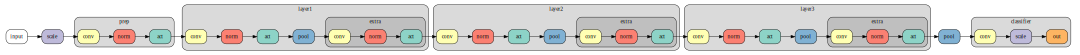

In [5]:
build_model(nets['simple']);

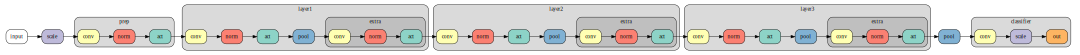

In [5]:
# new
build_model(nets['simple']);

#### Experiment: LR stress test

'batch norm' model


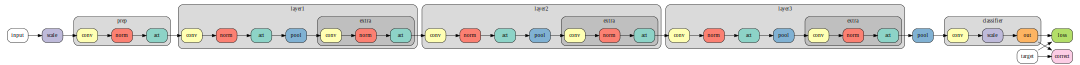

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:252: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)


       epoch   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       5.0661       2.2316       0.2130       0.4150       2.1232       0.2884       5.4812
           2       3.6447       2.0395       0.3147       0.1866       1.9218       0.3624       9.3125
           3       3.6350       1.8396       0.3778       0.1862       1.7010       0.4229      13.1338
           4       3.6355       1.6290       0.4442       0.1865       1.4789       0.4976      16.9558
           5       3.6360       1.4080       0.5229       0.1862       1.2732       0.5579      20.7780
           6       3.6375       1.1929       0.5916       0.2746       1.0916       0.6231      24.6901
           7       3.6377       1.0086       0.6526       0.1863       0.9769       0.6524      28.5142
           8       3.6384       0.8597       0.7040       0.1863       1.1248       0.6193      32.3389
           9       3.6355       0.7344       0.7471       0.1864

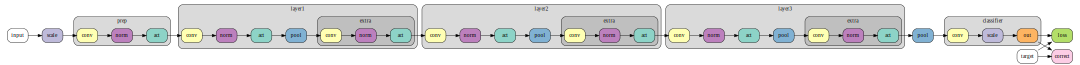

       epoch   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       3.1799       2.2011       0.1822       0.1542       1.9640       0.2879       3.3341
           2       3.2461       1.9041       0.3145       0.1519       1.7197       0.3871       6.7321
           3       3.1764       1.6979       0.3958       0.1519       1.5031       0.4636      10.0604
           4       3.1767       1.5869       0.4377       0.1527       1.4577       0.4935      13.3898
           5       3.1771       1.5021       0.4752       0.1517       1.2665       0.5491      16.7186
           6       3.1779       1.3501       0.5265       0.1519       1.2293       0.5694      20.0484
           7       3.1776       1.2586       0.5633       0.1519       1.1380       0.5938      23.3779
           8       3.1746       1.2010       0.5857       0.1517       0.9527       0.6755      26.7041
           9       3.2206       1.0571       0.6393       0.1516

In [6]:
#Run stress tests
batch_size = 512
epochs = 25
lrs = [0.005*2**(0.5*x) for x in range(epochs+1)]

experiments = {
    'batch norm': {},
    'no batch norm': {Normalise: (lambda c: Identity())},
}

data = []
for tag, overrides in experiments.items(): 
  print(f'\'{tag}\' model')
  model = build_model(nets['simple'], overrides=overrides, losses=losses())
  lr_schedule = PiecewiseLinear(np.array(range(epochs+1))*len(train_batches(batch_size)), lrs)*(1./batch_size) 
  optimiser = SGD(trainable_params(model).values(), {'lr': lr_schedule, 'weight_decay': Const(1e-4*batch_size), 'momentum': Const(0.9)})
  table = Table()
  train(model, [optimiser], range(epochs), train_batches(batch_size), valid_batches(batch_size), table=table) 
  data += [{'tag': tag, 'epoch': epoch+1, 'learning rate': lr, 'train acc': x['train']['acc']} for epoch, lr, x in zip(range(epochs), lrs[1:], table.log)]
  
#Plot the results
fig = {
  'lr': alt.Chart(pd.DataFrame(data)).mark_line().encode(x='epoch', y='learning rate'),
  'train acc': alt.Chart(pd.DataFrame(data)).mark_line().encode(x=alt.X('learning rate', scale=alt.Scale(type='log', base=10)), y='train acc', color='tag') 
}

'batch norm' model


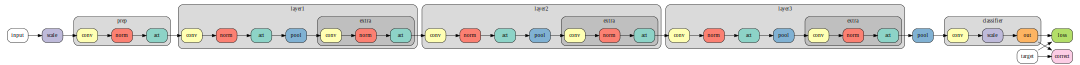

       epoch   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       2.8137       2.2196       0.2193       0.1872       2.0998       0.3261       3.0009
           2       2.7985       2.0049       0.3354       0.1867       1.8817       0.3856       5.9861
           3       2.7994       1.8043       0.3937       0.1869       1.6892       0.4347       8.9724
           4       2.8002       1.6074       0.4525       0.1928       1.4869       0.4831      11.9655
           5       2.8010       1.3914       0.5292       0.1869       1.2439       0.5770      14.9535
           6       2.8019       1.1827       0.5956       0.1868       1.1231       0.5963      17.9422
           7       2.8013       1.0101       0.6515       0.2632       1.0212       0.6444      21.0067
           8       2.8019       0.8701       0.6983       0.1877       0.8244       0.7085      23.9964
           9       2.8042       0.7488       0.7433       0.1875

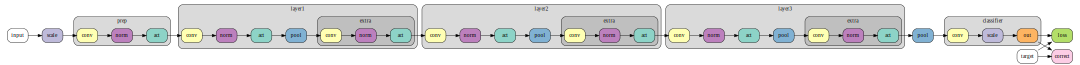

       epoch   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       2.3528       2.1890       0.1968       0.1530       1.9170       0.3086       2.5058
           2       2.3428       1.8621       0.3303       0.2295       1.6698       0.4112       5.0782
           3       2.3399       1.6846       0.4007       0.1525       1.4776       0.4794       7.5706
           4       2.3422       1.5800       0.4436       0.1601       1.3947       0.5107      10.0729
           5       2.3417       1.4465       0.4922       0.1524       1.3108       0.5514      12.5670
           6       2.3384       1.4069       0.5090       0.1523       1.2399       0.5664      15.0577
           7       2.3421       1.2823       0.5522       0.1522       1.0420       0.6382      17.5521
           8       2.3417       1.2177       0.5823       0.1735       0.9263       0.6693      20.0673
           9       2.3377       1.1341       0.6133       0.1523

In [7]:
# new
#Run stress tests
batch_size = 512
epochs = 25
lrs = [0.005*2**(0.5*x) for x in range(epochs+1)]

experiments = {
    'batch norm': {},
    'no batch norm': {Normalise: (lambda c: Identity())},
}

data = []
for tag, overrides in experiments.items(): 
  print(f'\'{tag}\' model')
  model = build_model(nets['simple'], overrides=overrides, losses=losses())
  lr_schedule = PiecewiseLinear(np.array(range(epochs+1))*len(train_batches(batch_size)), lrs)*(1./batch_size) 
  optimiser = SGD(trainable_params(model).values(), {'lr': lr_schedule, 'weight_decay': Const(1e-4*batch_size), 'momentum': Const(0.9)})
  table = Table()
  train(model, [optimiser], range(epochs), train_batches(batch_size), valid_batches(batch_size), table=table) 
  data += [{'tag': tag, 'epoch': epoch+1, 'learning rate': lr, 'train acc': x['train']['acc']} for epoch, lr, x in zip(range(epochs), lrs[1:], table.log)]
  
#Plot the results
fig = {
  'lr': alt.Chart(pd.DataFrame(data)).mark_line().encode(x='epoch', y='learning rate'),
  'train acc': alt.Chart(pd.DataFrame(data)).mark_line().encode(x=alt.X('learning rate', scale=alt.Scale(type='log', base=10)), y='train acc', color='tag') 
}

#### Results



In [7]:
fig['lr'] | fig['train acc']

alt.HConcatChart(...)


The learning rate, plotted on the left, is increased exponentially over time, as a stress test. Training accuracy is plotted on the right. 

It can be seen that the network with batch norm is stable over a much larger range of learning rates (note the log scale on the x-axis in the second plot. ) The ability to use high learning rates allows training to proceed much more rapidly for the model with batch norm.

首先绘制的学习率，作为压力测试，随时间呈指数增长。第二个图显示了训练的准确性。

可以看出，具有batch norm的网络在更大的学习率范围内是稳定的(请注意第二个图中x轴上的日志刻度)。使用高学习率的能力允许对具有batch norm的模型进行更快的训练。

**学习率指数级增长，不加bn的训练很快出现问题。**

### The Bad

So why has so much effort been devoted to finding replacements? Batch norm has several drawbacks: 

那么，为什么要花这么多精力寻找替代品呢？batch norm有几个缺点：

- 速度很慢(虽然节点融合会有所帮助)
- 训练和测试是不同的，所以很脆弱
- 对于小的batch和不同的层类型无效
- 它具有多种相互作用的效果，很难分离。
- it's slow (although node fusion can help)
- it's different at training and test time and therefore fragile
- it's ineffective for small batches and various layer types
- it has multiple interacting effects which are hard to separate.


关于这些，我们今天没有太多要说的，只是说，一旦人们接受了batch norm之类的东西的必要性，解决这些问题似乎就容易得多了。特别是速度问题远非无法克服。一个好的编译器可以将统计数据的计算融合到上一层，并将应用融合到下一层，从而避免不必要的对内存的往返访问，并消除几乎所有的开销。

We won't have much to say on these today except to remark that once one has accepted the necessity of something like batch norm, addressing these issues seems a lot more palatable. The speed issue in particular is far from insurmountable. A good compiler could fuse the computation of statistics into the previous layer and application into the next, avoiding unneccessary round trips to memory and removing almost all overhead. 


希望今天的探索也能对batch norm的基本特性提供一些指导，这些特性是任何替换都需要的。

Hopefully today's explorations can also provide some guidance on the essential features of batch norm which would be required in any replacement.

## Deep nets and constant functions


The aim of this section is to understand the typical behaviour of deep networks at initialisation. We shall see hints of the problems to come when we start training. In particular care needs to be taken at initialisation if the network is to avoid computing a constant function, independent of the inputs. We shall review the surprising and under-appreciated fact that the standard He-et-al initialisation produces effectively constant functions for sufficiently deep ReLU networks.


深度网络和常数函数
本节的目的是了解深度网络在初始化时的典型行为。当我们开始训练时，我们将看到问题的迹象。如果网络要避免计算与输入无关的常数函数，在初始化时尤其需要注意。我们将回顾一个令人惊讶和被低估的事实，即标准的He-et-al初始化为足够深的ReLU网络提供了有效的常数函数。


### Per channel histograms

We come to the first key point. Batch norm acts on _histograms_ of _per channel_ activations (by shifting means and rescaling variances), which means that these are a really good thing to monitor. This seems to be rarely done, even in papers studying batch norm. A notable exception is the recent paper of [Luther and Seung](https://arxiv.org/abs/1902.04942), which we shall discuss shortly.

The diagram below shows histograms of activation values, across pixels and examples in a batch, before and after a batch norm layer. Different channels are represented by different colours; the per channel mean is shown underneath; and minimum/maximum values per channel are indicated by the vertical ticks (the height of which is held constant between plots in units of probability density so that small ticks indicate a more peaked distribution.) Strictly, these are kernel density estimates rather than histograms. We display a maximum of 10 arbitraily selected channels per layer to avoid over-crowding.

We are going to be looking at lots of plots like these during the remainder of the post, so please take a moment to understand the details...

每个通道的直方图
我们来到第一个关键点。batch norm作用于每个通道上的激活直方图(通过偏移和重新调整方差)，这意味着这些是非常值得监视的。似乎很少有人这么做，即使在研究batch norm的论文中也是如此。一个值得注意的例外是Luther and Seung最近的论文：https://arxiv.org/abs/1902.04942，我们将很快对此进行讨论。

下图显示了激活值的直方图，这些值在batch中跨越像素和样本，在batch norm层之前和之后。不同的通道用不同的颜色表示，每个通道的平均值显示在下面，每个通道的最小/最大值由垂直ticks表示。严格地说，这些是核密度估计，而不是直方图。我们每层最多显示10个任意选择的通道，以避免过度拥挤。


以下的激活值进行统计


在接下来的文章中，我们将会看到很多类似的情节，所以请花点时间来理解细节……

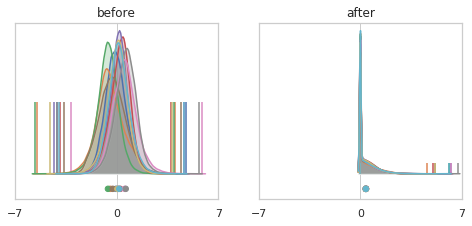

In [14]:
# new
model = build_model(nets['simple'], display_model=False)
output = model(next(iter(train_batches(512))))

layers = {'before': 'layer2_conv', 'after': 'layer2_act'}
fig = {name: channel_plot(output[layer], title=name) for name, layer in layers.items()}

layout([
    [fig['before'], fig['after']]
]);

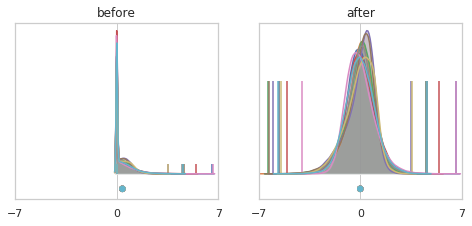

In [15]:
model = build_model(nets['simple'], display_model=False)
output = model(next(iter(train_batches(512))))

layers = {'before': 'layer2_act', 'after': 'layer2_norm'}
fig = {name: channel_plot(output[layer], title=name) for name, layer in layers.items()}

layout([
    [fig['before'], fig['after']]
]);

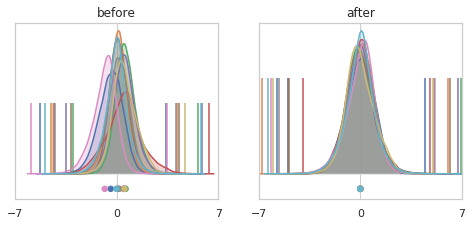

In [16]:
model = build_model(nets['simple'], display_model=False)
output = model(next(iter(train_batches(512))))

layers = {'before': 'layer2_conv', 'after': 'layer2_norm'}
fig = {name: channel_plot(output[layer], title=name) for name, layer in layers.items()}

layout([
    [fig['before'], fig['after']]
]);



Following Luther and Seung, let's consider a very boring network consisting of alternating fully-connected and ReLU layers, all the same size, and without batch norm. Here are the first 10 layers:

按照Luther和Seung的方法，让我们考虑一个非常无聊的网络，它由交替的全连接层和ReLU层组成，大小相同，没有batch norm。以下是前10层：




In [9]:
n_hidden = 2048
n_layers=50

torch.manual_seed(0) #set the random seed so that we can refer to a particular random outcome in the text..
net = {f'{layer}{i+1}': val for i in range(n_layers) for (layer,val) in [('fc', linear(n_hidden, n_hidden, bias=False)), ('relu', nn.ReLU())]}

fig = DotGraph(*graph(dict(list(net.items())[:10*2]))).svg()
SVG(fig)

We initialise the weights randomly using the standard [He-et-al](https://arxiv.org/abs/1502.01852) initialisation, which is aimed at preserving the mean and variance of layer outputs throughout the network _if we pool together the channels in a layer_. Actually, this is not exactly what the He-et-al initialisation does - it preserves mean and variance of outputs if we marginalise over the weights distribution, but this is close enough to pooling channels that we will ignore the difference here.

Let's look at histograms of channel activations at different depths in the network with independent $\mathcal{N}(0,1)$ inputs. First we look at pooled channel histograms, to check that the initialisation is doing what it is supposed to:

我们使用标准的He-et-al初始化随机初始化权重，该初始化的目的是，如果我们将一个层中的通道合并在一起，则可以保持整个网络中层输出的平均值和方差。实际上，这并不是He-et-al初始化的真正作用——如果我们将权重分布边缘化，它将保持输出的均值和方差，但这与通道池化非常接近，我们将忽略这里的差异。

我们来看看网络中不同深度的通道激活的直方图，其中有N(0,1)个输入。首先，我们看通道池化直方图，以检查初始化做了它该做的事情：

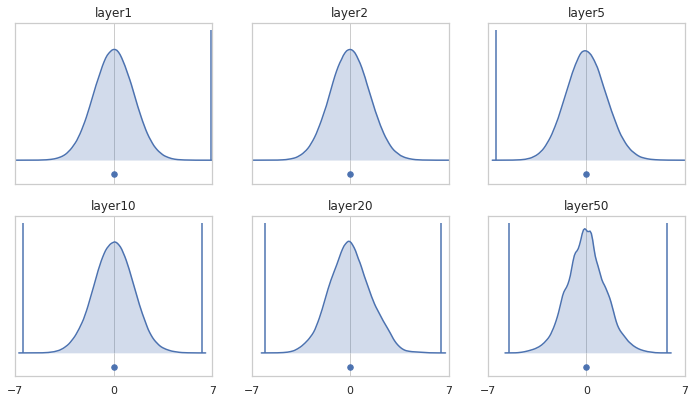

In [11]:
model = build_model(net, display_model=False)
random_batch = {'input': torch.tensor(np.random.randn(512, n_hidden)).to(dtype=torch.float16, device=device)}
output = model(random_batch)

layers = {f'layer{i}': f'fc{i}' for i in [1,2,5,10,20,50]}
fig = {name: channel_plot(output[layer].reshape(-1,1), title=name, nchannels=1) for name, layer in layers.items()}

layout([
    [fig['layer1'], fig['layer2'], fig['layer5']],
    [fig['layer10'], fig['layer20'], fig['layer50']],
], sharex=True);

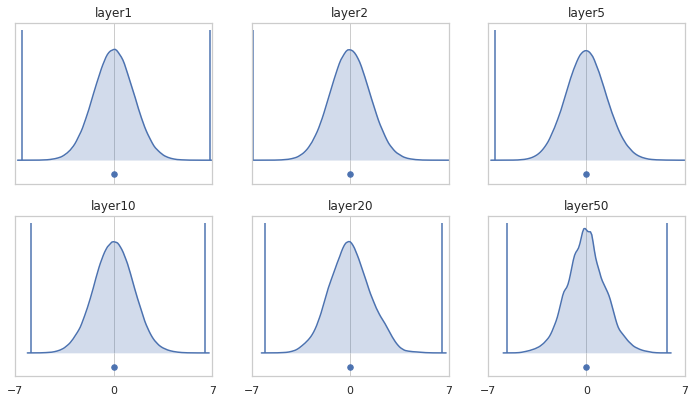

In [17]:
# new 
model = build_model(net, display_model=False)
random_batch = {'input': torch.tensor(np.random.randn(512, n_hidden)).to(dtype=torch.float16, device=device)}
output = model(random_batch)

layers = {f'layer{i}': f'fc{i}' for i in [1,2,5,10,20,50]}
fig = {name: channel_plot(output[layer].reshape(-1,1), title=name, nchannels=1) for name, layer in layers.items()}

layout([
    [fig['layer1'], fig['layer2'], fig['layer5']],
    [fig['layer10'], fig['layer20'], fig['layer50']],
], sharex=True);

Things get a bit wobbly by layer 50, but generally look how they should. 

Now let's look at the same histograms, split by channel:

在第50层的时候，会变得有点不稳定，但是通常情况下应该是这样的。

现在让我们看看同样的直方图，按通道分割：

没有bn层，随着训练epoch增加，每个channel的分布差异越来越大；

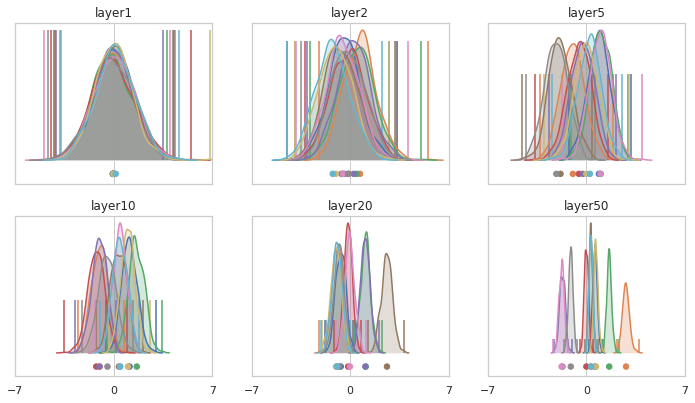

In [18]:
fig = {name: channel_plot(output[layer], title=name) for name, layer in layers.items()}

layout([
    [fig['layer1'], fig['layer2'], fig['layer5']],
    [fig['layer10'], fig['layer20'], fig['layer50']],
], sharex=True);

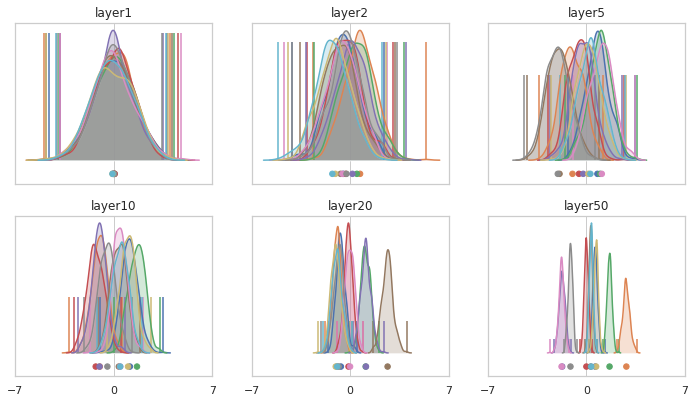

In [11]:
# new 
fig = {name: channel_plot(output[layer], title=name) for name, layer in layers.items()}

layout([
    [fig['layer1'], fig['layer2'], fig['layer5']],
    [fig['layer10'], fig['layer20'], fig['layer50']],
], sharex=True);

These tell a rather different story! 

By layer 50, each channel has effectively chosen a constant value to take, independently of the input. Suppose that layer 50 was the final layer before a softmax classifier (and only consisted of the 10 channels displayed.) Most inputs would be classified as belonging to the 'orange' class with a small number of 'greens' and nothing else. In this sense, a randomly initialised network likes to compute (almost) constant functions!

If we remove the ReLUs and rescale the weights appropriately so that we have a purely linear network, the problem goes away. At deeper layers, we eventually observe some variation between the variances of different channels but the effect is rather mild.

直方图表现出来的是非常不同的东西！

到第50层时，每个通道都高效地选择了一个要取的常数，与输入无关。假设第50层是softmax分类器之前的最后一层(只包含显示的10个通道)。大多数输入将被归类为“橙色”类，只有少量“绿色”，除此之外别无其他。从这个意义上说，一个随机初始化的网络喜欢计算(大多数)常数函数！

如果我们移除ReLUs并适当地重新调整权重，这样我们就得到了一个纯线性网络，问题就解决了。在较深的地层中，我们最终观察到不同通道之间的差异，但效果相当温和。

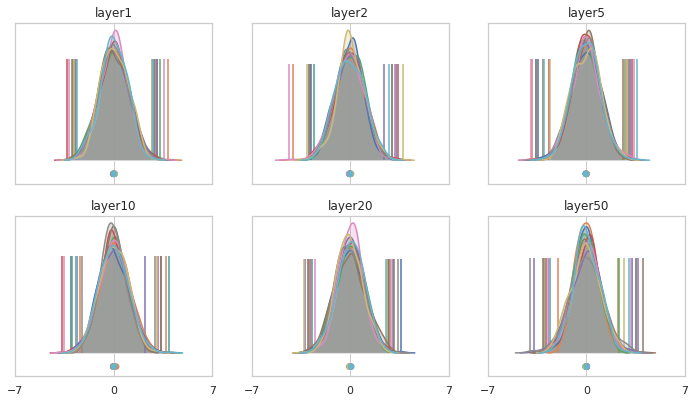

In [13]:
net = {f'{layer}{i+1}': val for i in range(n_layers) for (layer,val) in [('fc', linear(n_hidden, n_hidden, bias=False, weight_scale=np.sqrt(3)))]}
model = build_model(net, display_model=False)
output = model(random_batch)

fig = {name: channel_plot(output[layer], title=name) for name, layer in layers.items()}

layout([
    [fig['layer1'], fig['layer2'], fig['layer5']],
    [fig['layer10'], fig['layer20'], fig['layer50']],
], sharex=True);

#### Aside (Optional): SVDs, random matrices and all that



In fact, the per channel histograms are not telling the full story and there are significant correlations _between_ channels in deep layers. We 
see this if we compute the singular value decomposition of the linear map represented by the linear network to different depths:

其他的方法：SVDs，随机矩阵等等

事实上，每个通道的直方图并不能说明全部情况，在深层的通道之间有显著的相关性。如果我们计算线性网络表示的线性映射到不同深度的奇异值分解，可以看到：

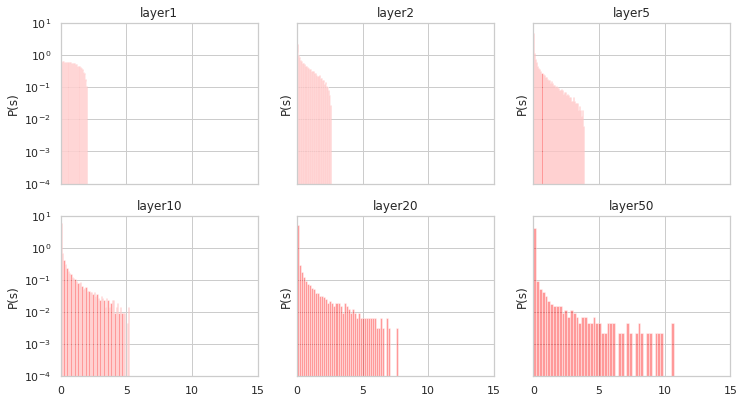

In [14]:
batch = {'input': torch.tensor(np.eye(n_hidden)).to(dtype=torch.float16, device=device)}
output = model(batch)
singular_values = {layer: np.linalg.svd(to_numpy(output[layer].transpose(1,0)).astype(np.float32))[1] for layer in layers.values()}

fig = {name: svd_plot(singular_values[layer], name, xlim=(0,15), xticks=[0,5,10,15], ylim=(1e-4, 10), yticks=(1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1), color='red') 
                        for name, layer in layers.items()}
layout([
    [fig['layer1'], fig['layer2'], fig['layer5']],
    [fig['layer10'], fig['layer20'], fig['layer50']],
], sharex=True, sharey=True);

By layer 50, certain combinations of channels have been stretched by a factor of ~10, a fact which is not visible in the per channel histograms. There is an elegant analysis based on random matrix theory and reviewed in [Pennington-et-al '17](https://arxiv.org/pdf/1711.04735.pdf) that explains what is going on here. We shall have nothing more to say on the matter here, since the effect is small compared to that of adding ReLU layers; since this effect will be greatly ameliorated with the addition of residual connections; and since the effects of batch norm, seeing only per channel statistics, are largely orthogonal to this.

到第50层时，某些通道的组合被拉伸了约10倍，这在每个通道直方图中是不可见的。在Pennington-et-al ' 17中有一个基于随机矩阵理论的优雅分析，解释了这里发生的事情。关于这个问题我们就不多说了，因为与添加ReLU层的效果相比，效果很小，由于这种效果在添加残差连接后将大大改善，而且由于batch norm的影响，只看到每个通道的统计数据，很大程度上是正交的。

### Fixing the ReLU network at initialisation

在初始化的时候固定ReLU网络

So how does the inclusion of ReLUs lead to the problems we observed above? It turns out that non-zero channel means introduced by the ReLU layers are at the root of the problem.
那么，包含ReLUs是如何导致我们在上面观察到的问题的呢？结果表明，由ReLU层引入的非零通道是问题的根源。

Since ReLUs only return positive values, the first time we pass a centred input distribution through a ReLU layer,  we get an output distribution in which each channel has positive mean. After the following linear layer, channels still have non-zero means, although these can now be positive or negative depending on the weights for the particular channel. This is because the output mean of a linear layer equals the linear layer applied to the input mean, which is non-zero as a result of the preceding ReLU. The key point is that for fixed weights,  per channel means are now non-zero, whilst if we average over the weights the effect disappears (by symmetry of the weights distribution around zero.)

由于ReLUs只返回正值，当我们第一次通过ReLU层传递一个集中的输入分布时，我们得到一个输出分布，其中每个通道的平均值都为正值。在下面的线性层之后，通道仍然有非零的平均值，尽管这些平均值现在可以是正的或负的，这取决于特定通道的权重。这是因为线性层的输出均值等于应用于输入均值的线性层，由于前面的ReLU，输入均值是非零的。关键是，对于固定的权重，每个通道的平均值现在都是非零的，而如果我们对权重进行平均，这种影响就会消失(通过权重分布在零附近的对称性)。


It is less obvious that this effect should continue to grow through the network, with means increasing in magnitude with depth. This is shown by a direct calculation in  [Luther and Seung '19](https://arxiv.org/abs/1902.04942) and also follows from 
straightforward properties of ReLU and the symmetry about zero of the weights distribution. 

不太明显的是，这种影响应该通过网络继续增长，其幅度随深度增加。这可以通过Luther and Seung ' 19中的直接计算得到，也可以从ReLU的直接性质和权值分布关于零的对称性得到。

The corresponding loss of variance within each channel follows from the [Law of total variance](https://en.wikipedia.org/wiki/Law_of_total_variance) which states that the total variance, integrating over the weights distribution - which is preserved by design under the He-et-al initialisation - decomposes into a sum of the variance of the per channel means and the average variance within each channel. (This decomposition is visible in the per channel histograms above for the ReLU network.) Since the per channel means increase in variance at each layer and the total variance is fixed, the variance within channels must decrease at each layer. At sufficient depth a fixed point is reached where there is no more variance within channels and the full variance is realised in the distribution of the per channel means. At this point the network is computing a constant function. 

相应损失的方差在每个通道遵循总方差法则，也就是说总方差，由权值分布集成而来—在使用He-et-al初始化的时候是保持不变的—分解成每个通道的方差的均值和每个通道的方差的和。(这种分解在上面ReLU网络的每个通道直方图中可见。)每一通道意味着每增加一层方差都会增加，而总方差是固定的，因此每一层通道内的方差必须减小。在足够的深度下，到达一个不动点，此时通道内没有更多的方差，并且在每个通道均值的分布中实现了完全方差。此时网络正在计算一个常数函数。


All of this suggests a rather simple fix: we should subtract the mean after each ReLU layer, and rescale to restore the total variance. In this simple network with $\mathcal{N}(0,1)$ input data, we can compute the relevant mean and scale factor analytically, but more generally, this corresponds to initialising with 'frozen batch norm' layers, which compute a static bias and scale to standardise the per channel means and variances at initialisation.

所有这些建议了一个相当简单的解决方案：我们应该减去每个ReLU层后的平均值，然后重新缩放以恢复总方差。在这个有N(0,1)输入数据的简单网络中，我们可以分析地计算相关的均值和比例因子，但更一般地说，这对应于使用“冻结的batch norm”层进行初始化，该层计算静态偏差和比例，以标准化初始化时的每个通道均值和方差。


With this fix in place, order is restored and the network no longer computes a constant function:

有了这个修正，秩序恢复了，网络不再计算一个常数函数：

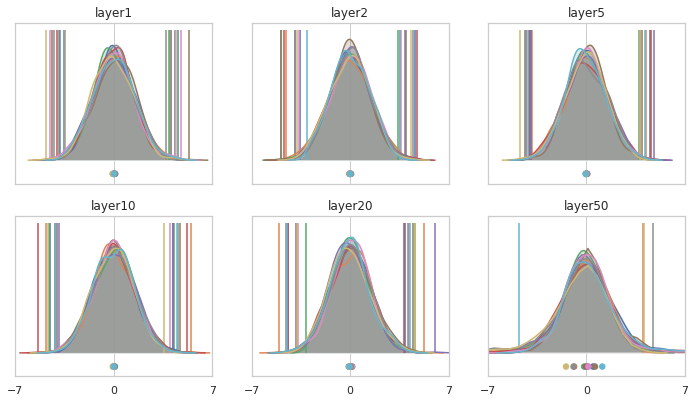

In [15]:
class ShiftScaleReLU(nn.Module):
  def forward(self, x):
    return (nn.functional.relu(x)- np.sqrt(1./np.pi))*(1./np.sqrt(1.-1./np.pi))

net = {f'{layer}{i+1}': val for i in range(n_layers) for (layer,val) in [('fc', linear(n_hidden, n_hidden, bias=False)), ('relu', ShiftScaleReLU())]}

model = build_model(net, display_model=False)
output = model(random_batch)

fig = {name: channel_plot(output[layer], title=name) for name, layer in layers.items()}

layout([
    [fig['layer1'], fig['layer2'], fig['layer5']],
    [fig['layer10'], fig['layer20'], fig['layer50']],
], sharex=True);

### What about a real network?

What happens in a more realistic setting with convolutions, pooling and real data?

Let's consider the 8-layer unbranched conv net from earlier, without batch norm layers. At initialisation with independent $\mathcal{N}(0,1)$ input data we get the following per channel output distributions:

真实的网络是什么情况？
在使用卷积、池化和实际数据的更现实的环境中会发生什么？

让我们考虑之前的8层无分支conv网络，没有batch norm层。在初始化独立的N(0,1)输入数据时，每个通道的输出分布如下：

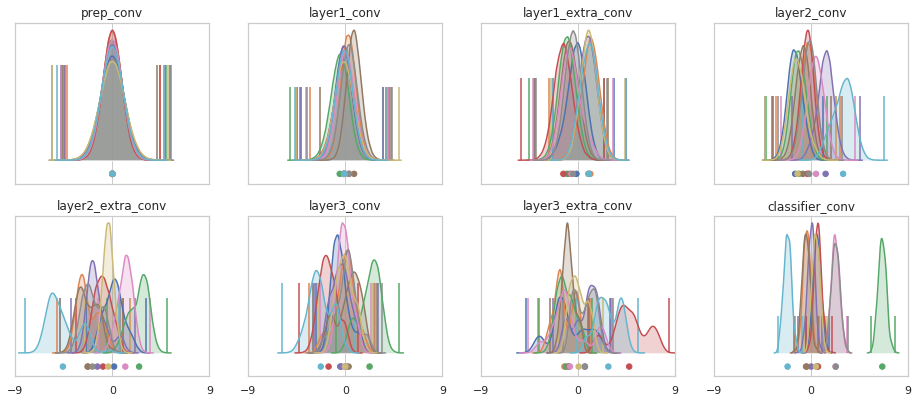

In [12]:
batch_size = 512
random_batch = {'input': torch.tensor(np.random.randn(batch_size,3,32,32)).to(dtype=torch.float16, device=device)}
model = build_model(nets['simple'], overrides={Normalise: (lambda c: Identity())}, display_model=False)
output = model(random_batch)
layers = [k for k,v in model.named_children() if 'conv' in k]

fig = {layer: channel_plot(output[layer], title=layer) for layer in layers}
layout(np.array(list(fig.values())).reshape(2,4), sharex=True, xlim=(-9,9));

The collapse to a constant function happens even more rapidly with this network! This is partly because of the inclusion of max-pooling layers which also act to increase channel-wise means. With CIFAR10 inputs things are slightly improved but the effect clearly persists:

在这个网络中，常数函数崩溃的速度更快！这在一定程度上是因为包含了最大池化层，它还可以增加每个通道的均值。使用CIFAR10输入，情况略有改善，但效果明显还在：

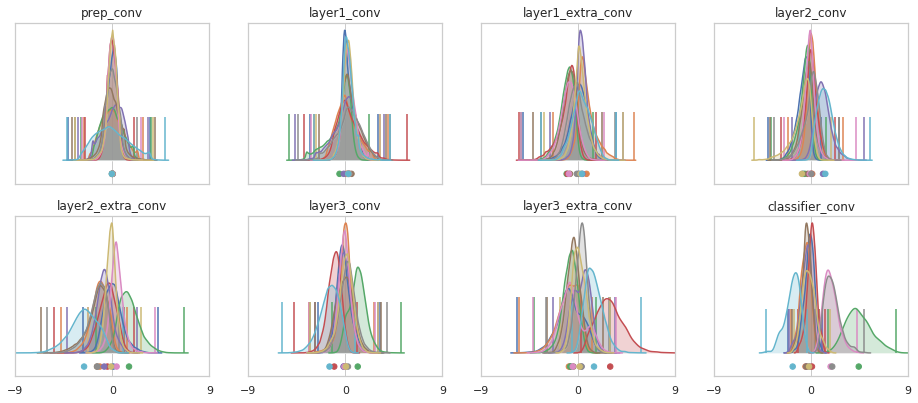

In [13]:
output = model(next(iter(train_batches(512))))
fig = {layer: channel_plot(output[layer], title=layer) for layer in layers}
layout(np.array(list(fig.values())).reshape(2,4), sharex=True, xlim=(-9,9));

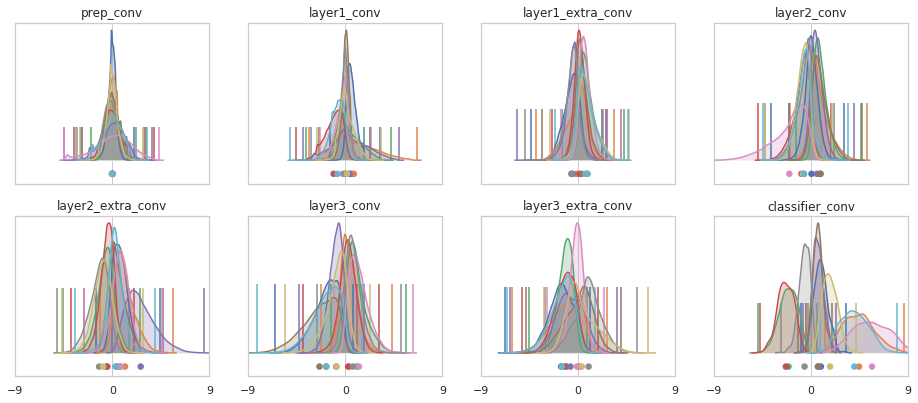

In [17]:
# new 
output = model(next(iter(train_batches(512))))
fig = {layer: channel_plot(output[layer], title=layer) for layer in layers}
layout(np.array(list(fig.values())).reshape(2,4), sharex=True, xlim=(-9,9));



If we reintroduce batch norm layers (or frozen batch norm layers) then, by design, intermediate layers revert to mean zero, variance one outputs per channel. This prevents any growth in per channel means throughout the network. However, the final classifier is not acted on by a batch norm layer (which would presumably restrict expressivity and hurt training perfomance.) Since the inputs to the classifier have passed through both a ReLU and a max-pooling layer, these inputs have substantial positive means already, leading to variance in per channel means at the classifer output. The effect is somewhat milder than for the network without batch norm, but it is by no means absent in this case:


如果我们重新引入batch norm层(或冻结的batch norm层)，那么通过设计，中间层将恢复为均值为零，每个通道的方差为1。这阻止了整个网络中每个通道的任何增长。然而，最终的分类器并没有受到batch norm层的影响(这可能会限制表达性并影响训练性能)。由于分类器的输入同时经过ReLU和max-pooling层，所以这些输入已经具有相当大的正均值，导致分类器输出时每个通道均值的变化。与没有batch norm的网络相比，这种影响稍微温和一些，但在这种情况下并不是不存在的：

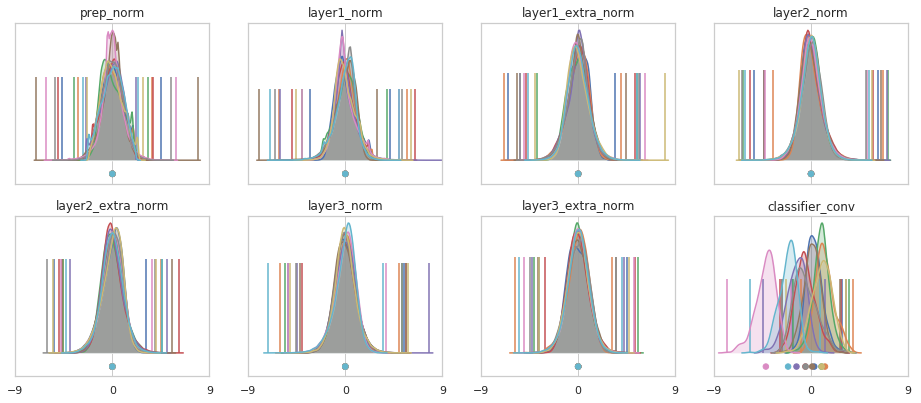

In [20]:
model = build_model(nets['simple'], display_model=False)
output = model(next(iter(train_batches(512))))

norm_layers = [l.replace('conv', 'norm') for l in layers[:-1]] + [layers[-1]]
fig = {layer: channel_plot(output[layer], title=layer) for layer in norm_layers}
layout(np.array(list(fig.values())).reshape(2,4), sharex=True, xlim=(-9,9));

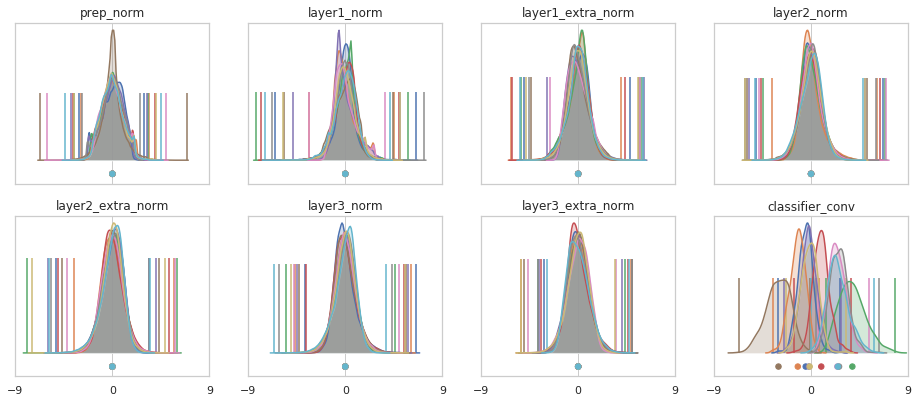

In [18]:
# new 
model = build_model(nets['simple'], display_model=False)
output = model(next(iter(train_batches(512))))

norm_layers = [l.replace('conv', 'norm') for l in layers[:-1]] + [layers[-1]]
fig = {layer: channel_plot(output[layer], title=layer) for layer in norm_layers}
layout(np.array(list(fig.values())).reshape(2,4), sharex=True, xlim=(-9,9));

### Recap

做个小结
到目前为止我们学到了什么？

What have we learned so far? 

In the absence of batch norm, the standard initialisation scheme for deep networks leads to 'bad' configurations in which the network effectively computes a constant function. By design, batch norm goes a long way towards fixing this. As far as initialisation is concerned - 'frozen batch norm', based on activation statistics at initialisation - works just as well.

在没有batch norm的情况下，深度网络的标准初始化方案会导致“糟糕”的配置，在这种配置中，网络可以有效地计算出常数函数。通过设计，batch norm在解决这个问题上走了很长的路。就初始化而言——基于初始化时的激活统计数据的“冻结的batch norm”也同样有效。


A more interesting question, which we turn to next, is what happens when we start training? We shall find that the ubiquity of bad network configurations at initialisation reflects a deeper problem: in the absence of batch norm, there are bad configurations in a small neighbourhood of the good configurations traversed during a training run. The proximity of these bad configurations - with high training loss - indicates the existence of highly curved directions in the loss landscape and places a limit on the achievable learning rates. 
下一个更有趣的问题是，当我们开始训练时会发生什么？我们将发现，在初始化时，坏的网络配置的普遍性反映了一个更深层次的问题：在没有batch norm的情况下，在训练运行期间所遍历的好的配置的一个小邻域中存在坏的配置。这些错误配置的接近性—高训练损失—表明在损失范围内存在高度弯曲的方向，并限制了可实现的学习率。

## Training stability

训练稳定性
其余部分的结构如下。
The remaining sections are structured as follows.

- First we describe three partially trained networks to compare: one with batch norm, one without and the third trained with batch norm which is subsequently frozen. 
- We show that for the two networks without active batch norm, one can use backprop to find nearby parameter configurations which produce constant outputs and thus achieve a high training loss. 
- We review the relation between curvature of the training loss - in the form of eigenvalues of the Hessian -  and instabilities of SGD.
- We then compute the leading eigenvalues and eigenvectors of the Hessian for our three networks. We find that the networks without batch norm have a small number of outlying eigenvalues which greatly limit the achievable learning rates. We show how the corresponding eigenvectors are related to the nearby 'bad' parameter configurations that we found.


- 首先，我们描述了三个部分训练的网络进行比较：
一个有batch norm，
一个没有batch norm，
第三个是冻结的batch norm。

- 我们证明，对于没有活动batch norm的两个网络，可以使用backprop找到附近产生恒定输出的参数配置，从而获得较高的训练损失。
- 我们以Hessian征值的形式研究了训练损失的曲率与SGD不稳定性之间的关系。
- 然后计算三个网络的主要特征值和特征向量。我们发现，没有batch norm的网络具有少量的孤立特征值，这极大地限制了可达的学习率。我们展示了相应的特征向量是如何与我们发现的附近的“坏”参数配置相关联的。

### Networks

We shall continue to work with the 8-layer unbranched network from above, with and without batch norm, with one minor alteration. Since we shall shortly be computing second derivatives using autograd, we are going to replace the ReLU non-linearity - whose second derivative vanishes almost everywhere and is therefore invisible to autograd - with a smoothed-out version. We choose to use the so-called 'softplus' non-linearity but the details are unimportant. This may be an unnecessary precaution but at least shouldn't hurt. We continue to refer to the (smoothed) non-linearity as ReLU below.


网络

我们将继续使用上面的8层无分支网络，使用或不使用batch norm，只有一个小的改动。由于我们将很快使用autograd计算二阶导数，我们将用一个平滑的版本替换ReLU非线性——它的二阶导数几乎到处都是消失的，因此autograd看不到它。我们选择使用所谓的“softplus”非线性，但细节并不重要。这可能是不必要的预防措施，但至少不应该造成伤害。我们继续把(平滑的)非线性称为下面的ReLU。

In [21]:
funcs = {
    'relu': nn.ReLU(False),
    'softplus': nn.Softplus(10, threshold=2.5),
}

xs = torch.tensor(np.arange(-2., 2.0, 0.01))
data = pd.DataFrame([{'func': k, 'x': float(to_numpy(x)), 'y': float(to_numpy(f(x)))} for x in xs for k,f in funcs.items()])
alt.Chart(data).mark_line().encode(x='x', y='y', color='func')

Chart({
  data:          func     x             y
  0        relu -2.00  0.000000e+00
  1    softplus -2.00  2.061154e-10
  2        relu -1.99  0.000000e+00
  3    softplus -1.99  2.277927e-10
  4        relu -1.98  0.000000e+00
  5    softplus -1.98  2.517499e-10
  6        relu -1.97  0.000000e+00
  7    softplus -1.97  2.782266e-10
  8        relu -1.96  0.000000e+00
  9    softplus -1.96  3.074880e-10
  10       relu -1.95  0.000000e+00
  11   softplus -1.95  3.398268e-10
  12       relu -1.94  0.000000e+00
  13   softplus -1.94  3.755667e-10
  14       relu -1.93  0.000000e+00
  15   softplus -1.93  4.150654e-10
  16       relu -1.92  0.000000e+00
  17   softplus -1.92  4.587182e-10
  18       relu -1.91  0.000000e+00
  19   softplus -1.91  5.069620e-10
  20       relu -1.90  0.000000e+00
  21   softplus -1.90  5.602796e-10
  22       relu -1.89  0.000000e+00
  23   softplus -1.89  6.192048e-10
  24       relu -1.88  0.000000e+00
  25   softplus -1.88  6.843271e-10
  26       relu -1.87  0.000000e+00
  27   softplus -1.87  7.562984e-10
  28       relu -1.86  0.000000e+00
  29   softplus -1.86  8.358390e-10
  ..        ...   ...           ...
  770      relu  1.85  1.850000e+00
  771  softplus  1.85  1.850000e+00
  772      relu  1.86  1.860000e+00
  773  softplus  1.86  1.860000e+00
  774      relu  1.87  1.870000e+00
  775  softplus  1.87  1.870000e+00
  776      relu  1.88  1.880000e+00
  777  softplus  1.88  1.880000e+00
  778      relu  1.89  1.890000e+00
  779  softplus  1.89  1.890000e+00
  780      relu  1.90  1.900000e+00
  781  softplus  1.90  1.900000e+00
  782      relu  1.91  1.910000e+00
  783  softplus  1.91  1.910000e+00
  784      relu  1.92  1.920000e+00
  785  softplus  1.92  1.920000e+00
  786      relu  1.93  1.930000e+00
  787  softplus  1.93  1.930000e+00
  788      relu  1.94  1.940000e+00
  789  softplus  1.94  1.940000e+00
  790      relu  1.95  1.950000e+00
  791  softplus  1.95  1.950000e+00
  792      relu  1.96  1.960000e+00
  793  softplus  1.96  1.960000e+00
  794      relu  1.97  1.970000e+00
  795  softplus  1.97  1.970000e+00
  796      relu  1.98  1.980000e+00
  797  softplus  1.98  1.980000e+00
  798      relu  1.99  1.990000e+00
  799  softplus  1.99  1.990000e+00
  
  [800 rows x 3 columns],
  encoding: FacetedEncoding({
    color: Color({
      field: 'func',
      type: 'nominal'
    }),
    x: X({
      field: 'x',
      type: 'quantitative'
    }),
    y: Y({
      field: 'y',
      type: 'quantitative'
    })
  }),
  mark: 'line'
})

我们想了解网络在训练过程中的典型状态。我们将使用前一篇文章中的线性热身和衰减策略，研究经过10个训练阶段后的网络——典型训练运行的中途阶段。由于没有batch norm的网络在较高的学习率下是不稳定的，因此最大学习率必须根据网络进行调整。这些选择相当武断，但结论似乎是可靠的。特别是在经过整整20个epochs的训练后所进行的实验产生了类似的结果，而准确的最高学习率和策略似乎并没有多大区别。

We want to understand the typical state of networks during training. We shall study the networks after 10 epochs of training - half-way through a typical training run - using the linear warm-up and decay schedule from previous posts. The maximal learning rate will have to be tailored to the network since the one without batch norm is unstable at higher learning rates. These choices are rather arbitrary but the conclusions appear to be robust. In particular experiments performed after a full 20 epochs of training produce similar results and the exact maximal learning rates and schedules don't appear to make a large difference.

我们考虑第三个网络，与batch norm相同，经过10个训练阶段后，batch norm层将冻结。这使我们能够将初始化和训练轨迹的问题与batch norm的持续稳定效果分离开来。我们将发现，没有激活的batch norm层的两个网络的行为相似，并且与batch norm网络完全不同。

We shall consider a third network, identical to the batch norm network, with the batch norm layers frozen after the 10 epochs of training. This allows us to separate issues of initialisation and training trajectory from the ongoing stabilising effects of batch norm. We shall find that the two networks without active batch norm layers behave similarly to one another and entirely differently from the batch norm network.


关于学习率大小、梯度、Hessian特征值和参数空间中的扰动的表述只有在我们确定权重的比例时才真正有意义。正如我们在前一篇文章中所讨论的，有许多其他方法可以参数化这些权重尺度不同的相同网络，特别是在存在batch norm的情况下。

Statements about the size of learning rates, gradients, Hessian eigenvalues and perturbations in parameter space only really make sense once we fix the scale of the weights. As we discussed in the previous post, there are many alternative ways to parameterise the same network in which these weight scales differ, especially in the presence of batch norm. 

For comparisons between the 'batch norm' and 'frozen batch norm' networks, this is not an issue since they have identical parameters. For the 'no batch norm' network we have been careful to make sure that weight scales are the same at initialisation and similar after training to the other two. In particular we have added a 'label smoothing' term to the loss to help stabilise the scale of the networks during training. A more involved treatment, in which we tried to make scale invariant statements only, would produce similar conclusions.

#### Preparing the networks

First we setup the network with  batch norm and train for 10 epochs:

In [0]:
label_smoothing_loss = losses(1.0, 0.5)

def setup_and_train_partial(net, overrides, max_lr, epochs=20, batch_size=512, train_epochs=10):
  lr_schedule = PiecewiseLinear(np.array([0, 4, epochs])*len(train_batches(batch_size)), [0, max_lr, 0])*(1/batch_size)
  model = build_model(net, overrides, label_smoothing_loss)
  optimisers = [SGD(trainable_params(model).values(), {'lr': lr_schedule, 'weight_decay': Const(1e-4*batch_size), 'momentum': Const(0.9)})]
  train(model, optimisers, range(train_epochs), train_batches(batch_size), valid_batches(batch_size))
  return model

models = {}

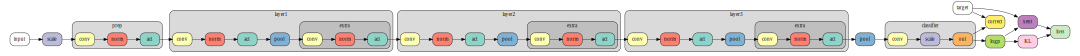

       epoch   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       4.5708       2.9268       0.4735       0.4612       2.7254       0.5941       5.0320
           2       2.7951       2.5269       0.7092       0.2229       2.6485       0.6618       8.0500
           3       2.7821       2.4374       0.7624       0.2300       2.5105       0.7161      11.0621
           4       2.7833       2.4222       0.7731       0.2228       2.6641       0.6627      14.0681
           5       2.7884       2.3818       0.7939       0.2357       2.3797       0.7941      17.0922
           6       2.7890       2.3364       0.8155       0.2262       2.5970       0.6758      20.1074
           7       2.8780       2.3097       0.8301       0.2283       2.4793       0.7379      23.2136
           8       2.7860       2.2924       0.8357       0.2236       2.3916       0.7871      26.2232
           9       2.7879       2.2671       0.8483       0.2333

In [4]:
overrides = {Activation: convert_node(partial(nn.Softplus, beta=10.0, threshold=2.5))} 
models['batch norm'] = setup_and_train_partial(nets['simple'], overrides, max_lr=5.0)


We reset training=True for this network so that batch norm is active in the experiments that follow:

In [0]:
models['batch norm'].train(True);

We create a 'frozen batch norm' model by making a clone of the batch norm model, refreshing the batch norm stats on the training set (since things are changing fast at this point in training and we want to make sure that the frozen stats are up-to-date) and setting training_mode=False:

In [0]:
#make a clone of the batch norm model
model = copy.deepcopy(models['batch norm'])

#update batch norm stats and freeze
for batch in train_batches(512):
  model(batch)
model.train(False)

models['frozen batch norm'] = model

Next let's setup the network without batch norm from the beginning (note the lower learning rate for this model):

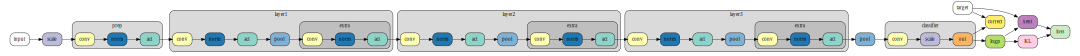

       epoch   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       2.4206       3.3371       0.2244       0.2106       3.1999       0.3201       2.6312
           2       2.3202       3.1338       0.3672       0.2198       2.9040       0.4990       5.1711
           3       2.3198       2.9410       0.4755       0.2132       2.9323       0.4755       7.7040
           4       2.3200       2.8545       0.5330       0.2231       2.7530       0.5806      10.2471
           5       2.3202       2.6957       0.6296       0.2130       2.5497       0.7156      12.7803
           6       2.3160       2.6093       0.6793       0.2119       2.5263       0.7275      15.3083
           7       2.3145       2.4885       0.7476       0.2123       2.5104       0.7353      17.8351
           8       2.3995       2.4209       0.7847       0.2218       2.3975       0.8083      20.4564
           9       2.3196       2.3765       0.8076       0.2174

In [7]:
overrides = {
  Activation: convert_node(partial(nn.Softplus, beta=10.0, threshold=2.5)),
  Normalise: (lambda c: Identity()),
}
models['no batch norm'] = setup_and_train_partial(nets['simple'], overrides, max_lr=0.2)

Finally, we convert the models to float32 format.  For the following experiments - some of which involve computing second derivatives and doing numerical linear algebra on the results - we are going to work in float32 to reduce the risk of numerical issues. This has the disadvantage of making things rather slow, but efficiency is not the priority here. Were we working with larger models/datasets, it might be worth doing the work to make these computations work correctly in mixed precision.

We also need a float32 version of the dataset and since we are not training further, we are going to fix the shuffled order and random choices of data augmentations to reduce noise when comparing between experiments. We use a smaller batch size here since computing Hessian vector products is rather memory intensive.To reproduce the experiments on a GPU smaller than a V100, a further reduction in batch size may be necessary and things are likely to be slow.


In [0]:
models = {name: model.float() for name, model in models.items()}
fixed_train_batches = list(train_batches(256, dtype=torch.float32))

### Finding bad configurations

找到不好的配置

我们给自己设定了以下任务：对于这三个部分训练过的网络，我们能否在参数空间中找到近似于常数函数的配置，并且相应的训练损失也很高？事实上，让我们将问题细化如下。我们能否在参数空间中找到附近的配置，使网络(大部分)输出一个固定的、选定的类？第二个问题适用于使用backprop的解决方案——我们可以根据所选类的平均分类器输出的模型参数计算梯度。我们可以在那个方向上扰动。



We set ourselves the following task: for each of the three, partially trained networks, can we find nearby configurations in parameter space that compute nearly constant functions with correspondingly high training loss? In fact, let's sharpen the question as follows. Can we find nearby configurations in parameter space such that the networks (mostly) output a fixed, chosen class? This second question is amenable to a solution using backprop - we can compute the gradient, with respect to model parameters, of the mean classifier output for the chosen class. We can then perturb in that direction. 

Let's put this into practice for our three networks. 

First, we compute gradients of the means of each of the 10 classifier outputs for each network:

首先，我们计算每个网络的10个分类器输出的平均值的梯度，

In [9]:
channel_means = lambda model, batch: model(batch)['classifier_out'].mean(0)

basis = lambda n_channels: torch.eye(n_channels, dtype=torch.float32, device=device)

channel_mean_grads = {}
for name, model in models.items():
  print(name)
  channel_mean_grads[name] = [to_numpy(compute_grad(model, fixed_train_batches, channel_means, vec)) for vec in basis(10)]

batch norm
frozen batch norm
no batch norm


然后在每个梯度方向上用一个固定长度的向量扰动。


Next we want to perturb by a fixed length vector in each of the gradient directions computed above.

The vector of learnable parameters of the three partially trained networks have approximately the same norm - indeed the 'batch norm' and 'frozen batch norm' networks have identical learnable parameters.

这三个部分训练的网络的可学习参数向量具有近似相同的范数——实际上“batch norm”和“冻结的batch norm”网络具有相同的可学习参数。


In [12]:
pd.DataFrame([{'model': name, 'params norm': float(torch.norm(to_vec(trainable_params(model).values())))} for name, model in models.items()])

,model,params norm
0,batch norm,61.205597
1,frozen batch norm,61.205597
2,no batch norm,60.043411


我们看看如果我们被固定长度的向量扰动1%的基础参数向量的长度会发生什么。作为基线，我们首先用一个长度为1%的随机向量来检查未扰动的、通道分布以及扰动参数的影响：

Let's see what happens if we perturb by fixed length vectors of 1% of the length of the underlying parameter vector. As a baseline, we first inspect the unperturbed, channel distributions and the effect of perturbing parameters by a random vector of 1% length:


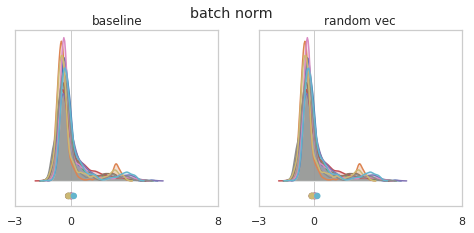

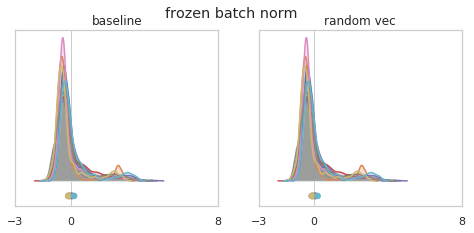

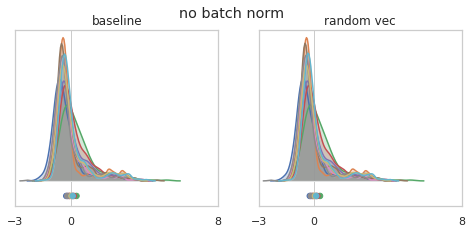

In [30]:
δ = 0.6 # 1% of the length of the parameter vector for the three networks

num_params = sum(p.numel() for p in trainable_params(models['batch norm']).values())
rand_vec = np.random.randn(num_params)
rand_vec = rand_vec / np.linalg.norm(rand_vec)

fig = {}
batch = next(iter(train_batches(512, dtype=torch.float32)))
for name, model in models.items():
  fig[name] = {k: channel_plot(perturbed_model(model, δ*vec)(batch)['classifier_scale'].detach(), title=k) for k, vec in {'baseline': np.zeros(num_params), 'random vec': rand_vec}.items()}

for name in models:
  layout(np.array(list(fig[name].values())).reshape(1,2), sharex=True, xlim=(-3,8), vline_height=None, figure_title=name);

关于上面的图，有几点需要注意。(注意，我们正在查看最后一层输出的缩放版本，而在初始化时，我们正在监视未缩放版本——输出的缩放是通过训练过程实现的。)

A few things to note about the plots above.  (Note that we are looking at a scaled version of the outputs of the final layer, whereas at initialisation we were monitoring the unscaled version - the scale of the outputs has grown through the training process.)

First, the three networks produce similar output distributions - indeed the 'batch norm' and 'frozen batch norm' outputs are almost indistinguishable, as one might hope. The distributions consist of a main mode and a second, smaller mode at some distance to the right which is characteristic of the network starting to make confident predictions of a single class per input. The overall distributions of different classes are similar, with no single class dominating, consistent with the ~85% training accuracy observed at this stage of training. Finally, the distributions after perturbation by a 1% length random vector are visually indistinguishable from the baseline.

首先，这三个网络产生了类似的输出分布——实际上，“batch norm”和“冻结的batch norm”的输出几乎是不可区分的，正如人们可能希望的那样。分布由一个主模式和另一个较小的模式组成，该模式在一定距离的右侧，这是网络的特点，开始对每个输入的单个类进行有信心的预测。不同类的总体分布情况相似，没有单一的类占主导地位，与现阶段所观察到的训练正确率约85%一致。最后，1%长度随机向量扰动后的分布与基线在视觉上无法区分。


Next, let's see what happens when we perturb by the gradients of channel means computed above, also normalised to 1% of the length of the underlying parameter vector.

接下来，让我们看看当我们被上面计算的通道平均值的梯度扰动时会发生什么，它也被归一化为底层参数向量长度的1%。为了节省空间，我们将只显示与前四通道平均值对应的扰动。


In [0]:
fig = {}

batch = next(iter(train_batches(512, dtype=torch.float32)))
for name, model in models.items():
  vecs = (δ*x/np.linalg.norm(x) for x in channel_mean_grads[name])
  fig[name] = {k: channel_plot(perturbed_model(model, vec)(batch)['classifier_scale'].detach(), title=f'channel {k}') for k,vec in enumerate(vecs, 1)}

First for the 'batch norm' model:
首先是“batch norm”模型：

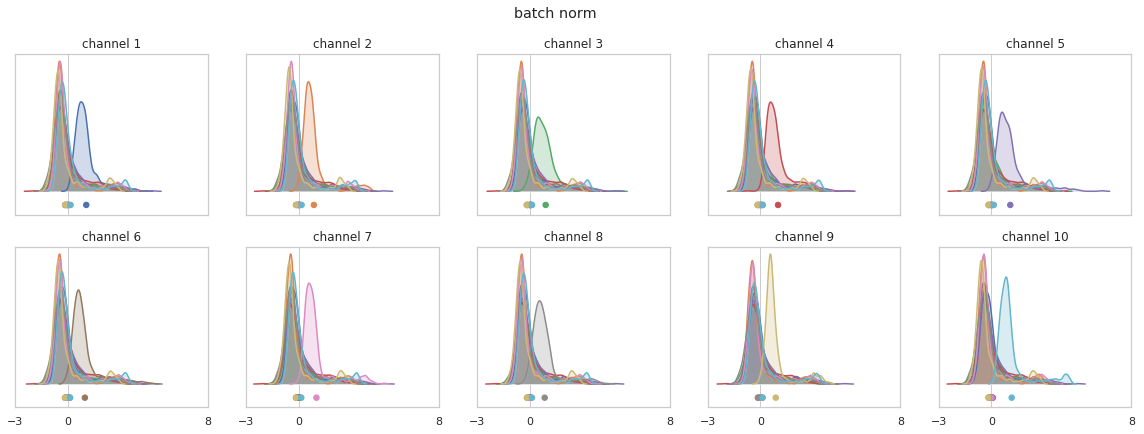

In [32]:
name = 'batch norm'
layout(np.array(list(fig[name].values())).reshape(2,5), sharex=True, xlim=(-3,8), vline_height=None, figure_title=name);

Unlike for a random vector of the same length, the effect of the targetted perturbations is clearly visible. However, this length of perturbation, is not sufficient to produce constant outputs and catastrophic loss in training accuracy.

与相同长度的随机向量不同，目标扰动的影响是明显可见的。然而，这种长度的扰动并不足以产生恒定的输出和灾难性的训练精度损失。

下一个是“冻结的batch norm”模型：

Next for the 'frozen batch norm' model:


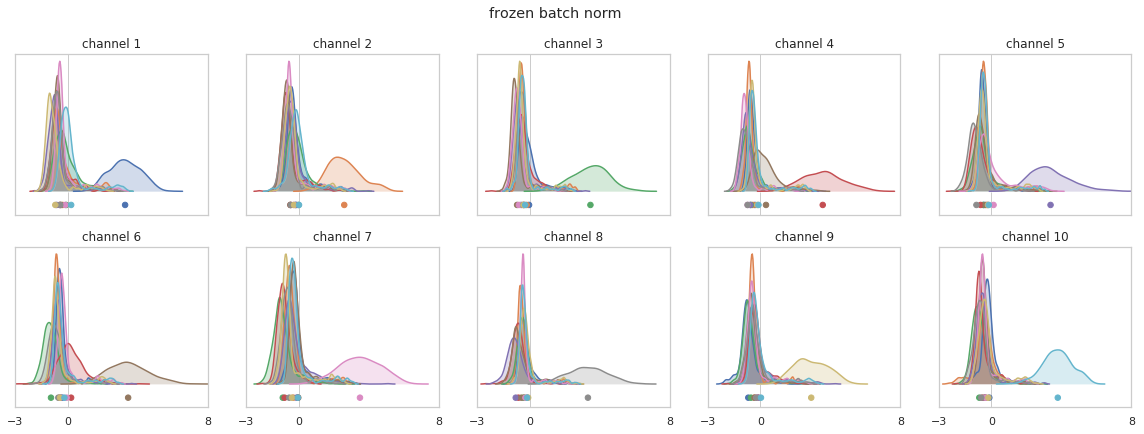

In [33]:
name = 'frozen batch norm'
layout(np.array(list(fig[name].values())).reshape(2,5), sharex=True, xlim=(-3,8), vline_height=None, figure_title=name);

Here the effect is much stronger! The perturbed networks predict the chosen class on a majority of inputs, leading to a dramatic increase in training loss.

这里的效果更强！受干扰的网络根据大多数输入预测所选的类别，导致训练损失的急剧增加。

“没有batch norm”模型的行为类似于“冻结的batch norm”模型：

The 'no batch norm' model behaves similarly to the 'frozen batch norm' model:

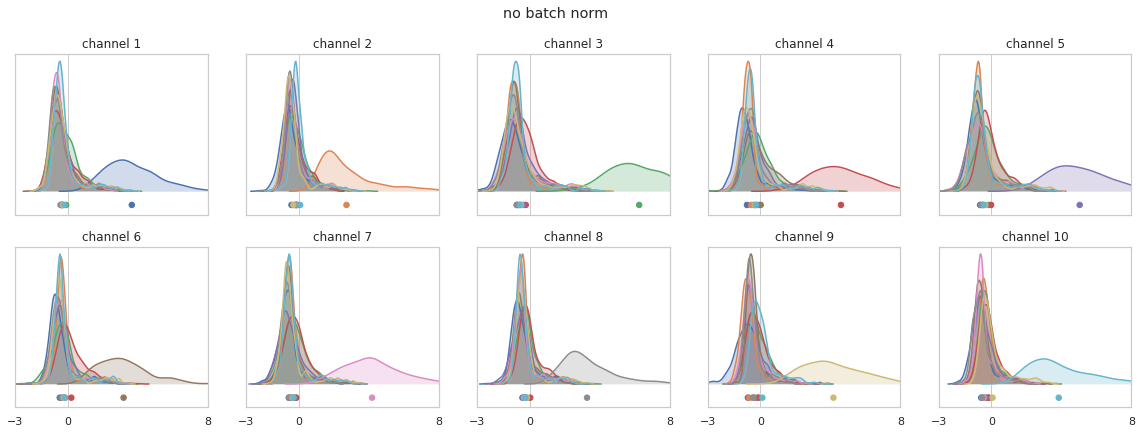

In [34]:
name = 'no batch norm'
layout(np.array(list(fig[name].values())).reshape(2,5), sharex=True, xlim=(-3,8), vline_height=None, figure_title=name);

What has happened here? To get further insight, let's have a look at the gradients of the mean channel outputs that we computed above. In particular, let's look at the squared norm of these gradients and how this is distributed between layers for each network. Since the effect is similar for all 10 output channels, we show the gradient for the first channel only:

这是怎么回事？为了得到更深入的了解，让我们看看上面计算的平均通道输出的梯度。特别地，让我们看看这些梯度的平方范数，以及它如何在每个网络的层之间分布。由于所有10个输出通道的效果都是相似的，所以我们只显示第一个通道的梯度：

In [35]:
channel=0
data = pd.DataFrame([{'model': name, 'param': k[:-7], '||dy/dW||^2': np.linalg.norm(v)**2} for name, model in models.items() 
                     for k,v in param_dict_from_vec(channel_mean_grads[name][channel], trainable_params(model)).items()])

alt.Chart(data).mark_bar().encode(x='model', y='||dy/dW||^2', color='model', column=alt.Column('param', sort=list(data['param'])))

Chart({
  data:                 model              param  ||dy/dW||^2
  0          batch norm          prep_conv     0.005609
  1          batch norm        layer1_conv     0.008952
  2          batch norm  layer1_extra_conv     0.011575
  3          batch norm        layer2_conv     0.022490
  4          batch norm  layer2_extra_conv     0.030885
  5          batch norm        layer3_conv     0.055983
  6          batch norm  layer3_extra_conv     0.316266
  7          batch norm    classifier_conv     2.304081
  8   frozen batch norm          prep_conv     0.111989
  9   frozen batch norm        layer1_conv     0.462095
  10  frozen batch norm  layer1_extra_conv     1.983222
  11  frozen batch norm        layer2_conv     2.483779
  12  frozen batch norm  layer2_extra_conv     4.232182
  13  frozen batch norm        layer3_conv     2.355610
  14  frozen batch norm  layer3_extra_conv     5.397092
  15  frozen batch norm    classifier_conv     2.300976
  16      no batch norm          prep_conv     0.781090
  17      no batch norm        layer1_conv     1.125868
  18      no batch norm  layer1_extra_conv     1.546298
  19      no batch norm        layer2_conv     1.850858
  20      no batch norm  layer2_extra_conv     2.799175
  21      no batch norm        layer3_conv     7.968436
  22      no batch norm  layer3_extra_conv    15.712179
  23      no batch norm    classifier_conv     6.441881,
  encoding: FacetedEncoding({
    color: Color({
      field: 'model',
      type: 'nominal'
    }),
    column: Column({
      field: 'param',
      sort: ['prep_conv', 'layer1_conv', 'layer1_extra_conv', 'layer2_conv', 'layer2_extra_conv', 'layer3_conv', 'layer3_extra_conv', 'classifier_conv', 'prep_conv', 'layer1_conv', 'layer1_extra_conv', 'layer2_conv', 'layer2_extra_conv', 'layer3_conv', 'layer3_extra_conv', 'classifier_conv', 'prep_conv', 'layer1_conv', 'layer1_extra_conv', 'layer2_conv', 'layer2_extra_conv', 'layer3_conv', 'layer3_extra_conv', 'classifier_conv'],
      type: 'nominal'
    }),
    x: X({
      field: 'model',
      type: 'nominal'
    }),
    y: Y({
      field: '||dy/dW||^2',
      type: 'quantitative'
    })
  }),
  mark: 'bar'
})

A couple of things to note. First, the gradient norms are much larger for the two networks without active batch norm. This is consistent with the results above: for a fixed length perturbation in the direction of the gradient, the effect on channel outputs is larger when the gradients are larger. Importantly, the gradient is concentrated in the final layer for the 'batch norm' network, but distributed throughout layers for the other two. We can understand this as follows. 

有几件事需要注意。首先，对于两个没有激活batch norm的网络，梯度范数要大得多。这与上面的结果一致：对于梯度方向上的定长扰动，梯度越大，对通道输出的影响越大。重要的是，梯度集中在“batch norm”网络的最后一层，而分布在其他两层。我们可以这样理解。

For the networks without active batch norm, changes to the distribution of outputs in earlier layers, can propagate to changes in distribution at later layers. In other words, _internal_ covariate shift is able to propagate to _external_ shift at the output layer. This is closely related to the issue at initialisation, where non-zero means at earlier layers propagate to non-zero means at later layers. Since the earlier layers receive inputs that have passed through a ReLU and have postive mean (even if the mean before ReLU was zero), the weights can easily be adapted to produce a change in output mean.  For the 'batch norm' network, changes to the mean and variance at earlier layers get removed by subsequent batch normalisation and so there is little opportunity for early layers to affect the output distribution.

对于没有激活batch norm的网络，输出在前一层分布的变化可以传播到后一层分布的变化。换句话说，内部协变量偏移能够在输出层传播到外部偏移。这与初始化时的问题密切相关，在初始化时，非零意味着在较早的层传播到较晚的层。由于较早的层接收经过ReLU并具有正平均值的输入(即使ReLU之前的平均值为零)，因此可以很容易地调整权重，以产生输出平均值的变化。对于“batch norm”网络，通过后续的batch norm可以消除对早期层的平均值和方差的更改，因此早期层影响输出分布的机会很小。

We can visualise what is going on in the case of the 'frozen batch norm' network by looking at channel distributions throughout the network after perturbation by the normalised gradient for the first output channel:

在第一个输出通道的正态梯度扰动后，我们可以透过观察整个网络的通道分布，直观地了解“冻结的batch norm”网络的情况：


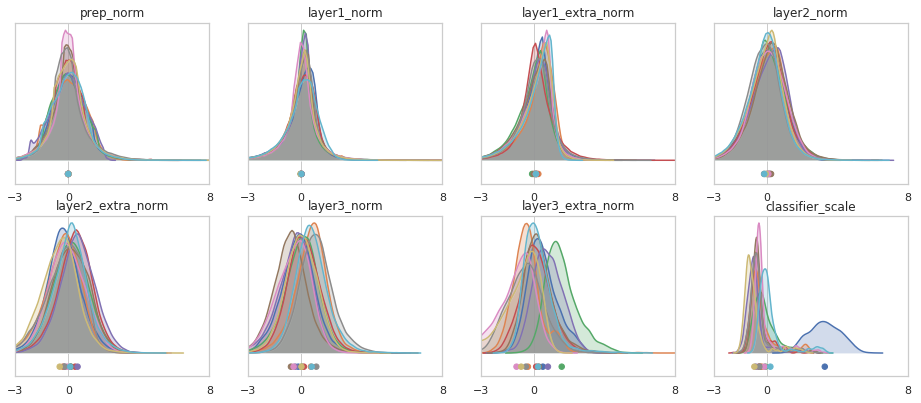

In [36]:
name, channel = 'frozen batch norm', 0
vec = channel_mean_grads[name][channel]
model = models[name]

model = perturbed_model(model, δ*vec / np.linalg.norm(vec))
output = model(batch)
fig = {layer: channel_plot(output[layer].detach(), title=layer) for layer in [k for (k,v) in model.named_children() if 'norm' in k or k =='classifier_scale']}

layout(np.array(list(fig.values())).reshape(2,4), xlim=(-3,8), vline_height=None);

The earlier layers - which had zero mean prior to perturbation, on account of the frozen batch norms - have increasingly large means as we progress through the layers, contributing to the large change for the targetted channel in the output. Apart from the shift in mean, little else changes from baseline in the per channel histograms, as the reader can verify by removing the perturbation.

较早的层—由于冻结的batch norm，在扰动之前的平均值为零—在我们通过这些层时具有越来越大的平均值，这导致了输出中目标通道的较大变化。除了平均值的变化外，每个通道直方图中与基线相比几乎没有其他变化。

#### Aside: Networks with batch norm after ReLU

在ReLu之后使用batch norm

在上面的讨论中，重要的一点是，由于ReLUs，早期层的传入激活具有非零均值，即使pre-ReLU激活具有零均值。这进而允许权重的扰动影响输出平均值。如果我们在ReLU层之后应用batch norm，然后在部分训练之后冻结，我们可能会看到另一种情况，在这种情况下，早期层的权重扰动的影响会大大减弱。(这与初始化时的情况很不一样，我们在简单的、全连接的网络中在ReLU之后使用了分析移位和缩，发现传播均值和常数输出的问题消失了。)


An important point, in the discussion above, was that incoming activations at early layers have non-zero mean on account of the ReLUs, even if pre-ReLU activations have  zero mean. This in turn allows perturbations of the weights to affect the output means. If we apply batch normalisation _after_ the ReLU layers and then freeze after partial training, we might expect a different story in which the effect of weight perturbations in early layers is greatly diminished. (This is analagous to the situation at initialisation where we applied an analytic shift and rescaling _after_ ReLU layers in the simple, fully connected net and found that the problem with propagating means and constant outputs disappeared.)

我们通过计算这样一个网络的输出通道均值的梯度，并绘制扰动的效果，来检验是否存在这种情况：

Let's check if this is the case by computing the gradients of output channel means for such a network. First we setup the network:

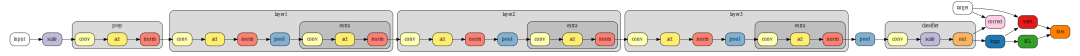

       epoch   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       2.8292       2.8528       0.5107       0.2283       2.6637       0.6607       3.0576
           2       2.8045       2.5105       0.7166       0.2189       2.5482       0.7027       6.0809
           3       2.8044       2.4249       0.7673       0.2262       2.4933       0.7418       9.1115
           4       2.8054       2.4086       0.7753       0.2217       2.4230       0.7684      12.1386
           5       2.8062       2.3585       0.8032       0.2203       2.3516       0.8051      15.1651
           6       2.9210       2.3120       0.8242       0.2184       2.3290       0.8076      18.3045
           7       2.8094       2.2872       0.8359       0.2186       2.3435       0.7982      21.3325
           8       2.8060       2.2730       0.8399       0.2183       2.3047       0.8235      24.3567
           9       2.8109       2.2400       0.8579       0.2170

In [37]:
#1. setup and train partially
overrides = {Activation: convert_node(partial(nn.Softplus, beta=10.0, threshold=2.5))} 
model = setup_and_train_partial(nets['post'], overrides, max_lr=5.0)

#2. update batch norm stats and freeze
model.train(True)
for batch in train_batches(512):
  model(batch)
model.train(False)

model.float();

Next we compute channel mean gradients:

In [0]:
channel_mean_grads_post = [to_numpy(compute_grad(model, fixed_train_batches, channel_means, vec)) for vec in basis(10)]

...and plot the effect of perturbing by these:

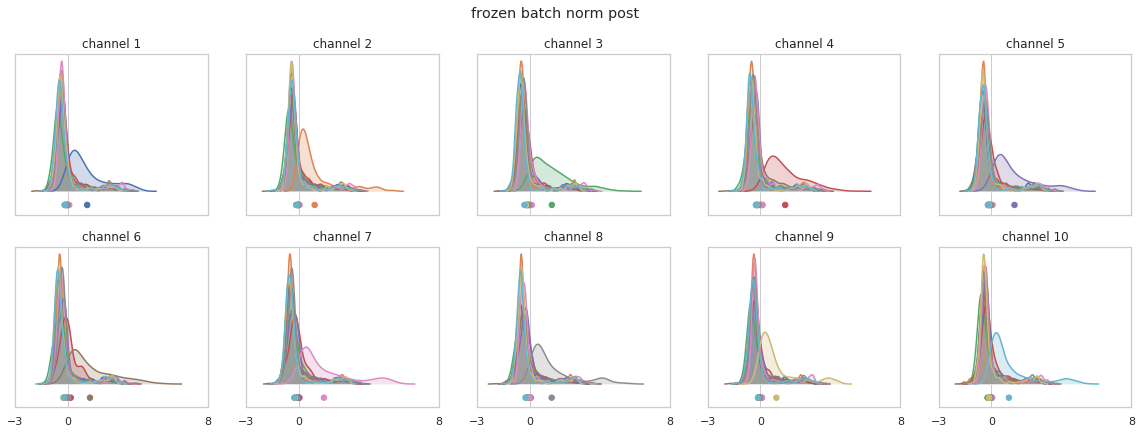

In [39]:
batch = next(iter(train_batches(512, dtype=torch.float32)))

vecs = (δ*x/np.linalg.norm(x) for x in channel_mean_grads_post)
fig = {k: channel_plot(perturbed_model(model, vec)(batch)['classifier_scale'].detach(), title=f'channel {k}') for k,vec in enumerate(vecs, 1)}
layout(np.array(list(fig.values())).reshape(2,5), sharex=True, xlim=(-3,8), vline_height=None, figure_title='frozen batch norm post');

扰动的影响要比没有batch norm的其他网络小得多，并且与batch norm网络的影响相似！同样地，如果我们检查单个输出通道梯度的平方范数，我们会发现这个网络的范数要小得多，而且主要集中在最后一层。

The impact of the perturbations is much smaller than for either of the other networks without active batch norm and and similar to that of the batch norm network! Similarly, if we inspect the squared norm of gradient of a single output channel then we find that the norm is much smaller for this network and mostly concentrated in the final layer.

In [40]:
channel=0
name = 'frozen batch norm post'

channel_mean_grads_all = union(channel_mean_grads, {name: channel_mean_grads_post})
models_all = union(models, {name: model})

data = pd.DataFrame([{'model': name, 'param': k[:-7], '||dy/dW||^2': np.linalg.norm(v)**2} for name, model in models_all.items() 
                     for k,v in param_dict_from_vec(channel_mean_grads_all[name][channel], trainable_params(model)).items()])

alt.Chart(data).mark_bar().encode(x=alt.X('model', sort=None), y='||dy/dW||^2', color=alt.Color('model', sort=None), column=alt.Column('param', sort=list(data['param'])))

Chart({
  data:                      model              param  ||dy/dW||^2
  0               batch norm          prep_conv     0.005609
  1               batch norm        layer1_conv     0.008952
  2               batch norm  layer1_extra_conv     0.011575
  3               batch norm        layer2_conv     0.022490
  4               batch norm  layer2_extra_conv     0.030885
  5               batch norm        layer3_conv     0.055983
  6               batch norm  layer3_extra_conv     0.316266
  7               batch norm    classifier_conv     2.304081
  8        frozen batch norm          prep_conv     0.111989
  9        frozen batch norm        layer1_conv     0.462095
  10       frozen batch norm  layer1_extra_conv     1.983222
  11       frozen batch norm        layer2_conv     2.483779
  12       frozen batch norm  layer2_extra_conv     4.232182
  13       frozen batch norm        layer3_conv     2.355610
  14       frozen batch norm  layer3_extra_conv     5.397092
  15       frozen batch norm    classifier_conv     2.300976
  16           no batch norm          prep_conv     0.781090
  17           no batch norm        layer1_conv     1.125868
  18           no batch norm  layer1_extra_conv     1.546298
  19           no batch norm        layer2_conv     1.850858
  20           no batch norm  layer2_extra_conv     2.799175
  21           no batch norm        layer3_conv     7.968436
  22           no batch norm  layer3_extra_conv    15.712179
  23           no batch norm    classifier_conv     6.441881
  24  frozen batch norm post          prep_conv     0.070571
  25  frozen batch norm post        layer1_conv     0.069745
  26  frozen batch norm post  layer1_extra_conv     0.259637
  27  frozen batch norm post        layer2_conv     0.071781
  28  frozen batch norm post  layer2_extra_conv     0.394348
  29  frozen batch norm post        layer3_conv     0.115397
  30  frozen batch norm post  layer3_extra_conv     0.655119
  31  frozen batch norm post    classifier_conv     1.177031,
  encoding: FacetedEncoding({
    color: Color({
      field: 'model',
      sort: None,
      type: 'nominal'
    }),
    column: Column({
      field: 'param',
      sort: ['prep_conv', 'layer1_conv', 'layer1_extra_conv', 'layer2_conv', 'layer2_extra_conv', 'layer3_conv', 'layer3_extra_conv', 'classifier_conv', 'prep_conv', 'layer1_conv', 'layer1_extra_conv', 'layer2_conv', 'layer2_extra_conv', 'layer3_conv', 'layer3_extra_conv', 'classifier_conv', 'prep_conv', 'layer1_conv', 'layer1_extra_conv', 'layer2_conv', 'layer2_extra_conv', 'layer3_conv', 'layer3_extra_conv', 'classifier_conv', 'prep_conv', 'layer1_conv', 'layer1_extra_conv', 'layer2_conv', 'layer2_extra_conv', 'layer3_conv', 'layer3_extra_conv', 'classifier_conv'],
      type: 'nominal'
    }),
    x: X({
      field: 'model',
      sort: None,
      type: 'nominal'
    }),
    y: Y({
      field: '||dy/dW||^2',
      type: 'quantitative'
    })
  }),
  mark: 'bar'
})

这是一个解决稳定性问题的解决方案，而不需要激活的batch norm吗？不完全是。


Is this a solution to the stability problem without requiring active batch norm layers? Not quite. 

First of all, means can re-appear at early layers after freezing batch norms, because of random drift during subsequent training and once these are back, the instability reappears. Also, as we will see in the next section, there are other issues beyond output means. As an example, early layers can still control their output variance by rescaling weights, even in the absence of non-zero input means and since ReLU is a convex function, increasing (resp. decreasing) the variance of the distribution passed to ReLU is another way to increase (resp. decrease) the post-ReLU mean. 


首先，batch norm后，由于后续训练过程中的随机漂移，均值在早期层重新出现，一旦这些均值回来，不稳定性就会重新出现。此外，正如我们将在下一节中看到的，除了输出均值之外，还有其他问题。例如，即使在没有非零输入均值的情况下，由于ReLU是一个凸函数，递增的，早期层仍然可以通过重新调整权重来控制其输出方差。传递给ReLU的分布的方差是增加ReLU均值的另一种方法。



Having said this, the network with frozen batch norms after ReLUs is considerably more stable than the usual one and this is an intertesting direction for further investigation.

尽管如此，在ReLUs之后，使用batch norm的网络要比通常的网络稳定得多，这是进一步研究的方向。

### When gradient descent goes wrong

什么时候梯度下降会出问题

人们很容易陷入拟人化算法的陷阱，但梯度下降是一种相当原始的生物。它只有蚂蚁对周围景观的视角，没有记忆。由于发现自己处于一个足够陡峭的山谷中，这个算法观察到，当它沿着山谷两侧振荡时，梯度在不断增大。

It's easy to fall into the trap of anthropomorphising algorithms, but gradient descent is a rather primitive creature. It possesses an ant's-eye view of the surrounding landscape and no memory. Finding itself in a steep enough valley,  the poorly-named algorithm observes ever-growing gradients as it oscillates its way up the sides.

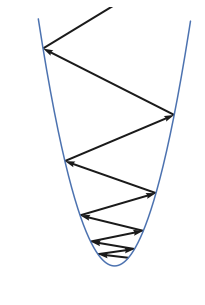

In [41]:
f = lambda x: 0.5*x*x

def gradient_descent_plot(lr):
  fig, ax = plt.subplots(figsize=(3,5))
  ax.axis('off')
  x0, xmax = 2.0, 11.0
  xs = np.arange(-xmax,xmax,0.05)
  ax.plot(xs, f(xs));
  xs = x0*(1.-lr)**np.arange(20) #ie x <- x - lr * f'(x)
  xs = xs[:np.searchsorted(np.abs(xs), xmax)+1]
  ys = f(xs)
  ax.quiver(xs[:-1], ys[:-1], xs[1:]-xs[:-1], ys[1:]-ys[:-1], scale_units='xy', angles='xy', scale=1, width=0.012);

gradient_descent_plot(lr=2.2)

#interactive plot works on Colab but not GCP backend..
#import ipywidgets as wds
#wds.interact(gradient_descent_plot, lr=wds.FloatSlider(value=2.2, min=1.8, max=2.5, step=0.05));  

对于两个没有激活的batch norm的网络，我们发现了附近的配置大多是输出的是常数且训练损失高的配置，说明我们发现自己处于这样一个陡峭的山谷中。如果我们能够证明这些是损失领域中“最”弯曲的方向，而类似的弯曲方向不存在于batch norm中，那么我们将相当准确地理解batch norm稳定优化和提高学习率的机制。为了进一步证明这一点，我们需要找到一种方法，来识别损失域中最弯曲的方向——那些对可达的学习率有最严格限制的方向。

For the two networks without active batch norm, we have discovered nearby configurations with mostly constant output and high training loss, indicating that we find ourselves in such a steep valley. If we can show that these are the _most_ curved directions in the loss landscape and that similarly curved directions do not exist in the presence of batch norm, then we shall have understood, rather precisely, the mechanism by which batch norm stabilises optimisation and enables higher learning rates. In order to make this further claim we need to have a way to identify the most curved directions in the loss landscape - those which place the tightest limit on achievable learning rates.

In one dimension, for a loss function $l(x)$, the gradient after taking a step $x \leftarrow x - \eta v$ is:


在一维中，对于损失函数l(x)，一个步骤之后的梯度x←x–ηv：

$$l'(x-\eta v) \approx l'(x) - \eta l''(x) v.$$

In the case of gradient descent $v = l'(x)$ and the update in terms of $l'$ is:

在梯度下降之中，v=l′(x)，在l′中的更新为：

$$l' \leftarrow (1 - \eta l''(x)) l'$$ 

Assuming that $l''(x) > 0$, the highest stable learning rate is:

假设l”(x)>0，最高的稳定学习率为：

$$ \eta = \frac{2}{l''(x)},$$

beyond which gradients and losses grow exponentially with time as in the picture above.

超过这个范围，梯度和损失会随着时间呈指数增长，如上图所示。

In higher dimensions, the gradient after taking a step in direction $\mathbf{v}$ is:

在高维情况下，向v方向迈出一步后的梯度为：

$$ l'(\mathbf{x} - \eta \mathbf{v}) \approx l'(\mathbf{x}) - \eta \mathbf{H v}$$

where $\mathbf{H}$ is the matrix of second derivatives of $l$, known as the Hessian. The update in terms of $l'$ is 

其中，H是l的二阶导数矩阵，也就是Hessian矩阵，在l′中的更新为：

$$l' \leftarrow (I -\eta \mathbf{H} )l'.$$

Assuming that all the eigenvalues of $\mathbf{H}$ are positive, the highest stable learning rate is determined by the largest eigenvalue  $\lambda_{\mathrm{max}}$:

假设所有H的特征值是正的，稳定的最高学习率由最大的特征值λmax：

$$\eta = \frac{2}{\lambda_{\mathrm{max}}}.$$

Adding momentum brings a little extra stability, as explained nicely [here](https://distill.pub/2017/momentum/), but the maximal learning rate is still limited by a constant times the reciprocal of $\lambda_{\mathrm{max}}$. This continues to hold in the presence of mild, localised non-convexity and well-behaved stochastic gradients.

增加momentum带来一些额外的稳定性，但最大的学习率仍然受限于一个常数乘以λmax的倒数。这在温和的、局部的非凸性和良好的随机梯度存在时仍然成立。


If SGD goes suddenly wrong with 'nan's appearing in losses and parameter values, large eigenvalues of the Hessian are usually (always?) the culprit. It doesn't matter if nearly all of the millions of directions in parameter space are nicely behaved - as soon as there is one direction corresponding to a large eigenvalue of the Hessian, SGD will find itself oscillating out of control. 

如果SGD突然在损失和参数值中出现 ‘nan’错误，Hessian矩阵的大特征值通常(总是)是罪魁祸首。如果参数空间中几乎所有的方向都表现得很好，这并不重要——只要有一个方向对应于Hessian矩阵的一个大特征值，SGD就会发现自己的振荡失去了控制。



In the next setion we shall show how to compute the leading eigenvalues/vectors of $\mathbf{H}$ and see how these relate to the nearby configurations with constant outputs that we identified earlier.


在下一节课中，我们将展示如何计算H的主要特征值/向量，并看看这些与我们前面确定的具有常数输出的邻近配置之间的关系。

### Computing the Hessian


计算Hessian矩阵
我们每个网络都有超过400万个可训练参数，因此直接计算Hessian矩阵将是非常痛苦的。
Our networks have over 4 million trainable parameters each, so direct computation of the Hessian is going to be painful.

幸运的是，如果我们只对主要特征值和特征向量感兴趣我们不需要这样做。
Fortunately, if we're only interested in the leading eigenvalues and eigenvectors we don't need to do this. 


当初始化一个随机向量时，同样的导致梯度下降不稳定的Hessian定理的重复应用，最终将生成一个与最大特征向量成比例的向量。由此可以很容易地计算出最大特征值。对这个向量进行正交并重复这个过程可以分离出子引导特征向量和特征值。这就是著名的Power方法。我们将使用稍微复杂一点的Lancsoz算法，基于相同的原则，通过scipy中的实现。

The same repeated application of the Hessian that leads to instability of gradient descent, will eventually produce a vector proportional to the maximal eigenvector, when initialised on a random vector. The maximal eigenvalue can be easily computed from this. Orthogonalising to this vector and repeating the process allows one to isolate sub-leading eigenvectors and eigenvalues. This is the well-known [Power method](https://en.wikipedia.org/wiki/Power_iteration). We shall use the slightly more sophisticated [Lancsoz algorithm](https://en.wikipedia.org/wiki/Lanczos_algorithm), based on the same principles, via an implementation in scipy.

We also need a way to compute Hessian vector products, which can be done using autograd via the well-known  _Pearlmutter trick_.  [This repo](https://github.com/noahgolmant/pytorch-hessian-eigenthings) provided a useful reference in developing the implementation below.

我们还需要一种计算Hessian向量积的方法，这可以使用autograd通过著名的Pearlmutter技巧来完成。这个repo：https://github.com/noahgolmant/pytorch-hessian-eigenthings为开发我们的实现提供了一个有用的参考。



In [0]:
import scipy.sparse.linalg
from itertools import count

loss_grad = lambda model, batch: to_vec(torch.autograd.grad(model(batch)['loss'].sum(), trainable_params(model).values(), create_graph=True))

class HvOperator(scipy.sparse.linalg.LinearOperator):
  def __init__(self, model, batches, projection=None):
    self.model, self.batches, self.projection = model, batches, projection
    params = list(trainable_params(model).values())
    size = int(sum(x.numel() for x in params))
    self.shape = (size, size)
    self.dtype, self.torch_dtype = np.dtype('float32'), params[0].dtype
    self.iteration, self.table, self.timer = count(1), Table(report_every=10), Timer()
  
  def _matvec(self, v):
    v = torch.tensor(v, dtype=self.torch_dtype, device=device)
    Hv = to_numpy(compute_grad(self.model, self.batches, loss_grad, v))
    self.table.append({'iteration': next(self.iteration), 'time': self.timer(), 'total time': self.timer.total_time})
    return self.projection(Hv) if self.projection else Hv

def compute_top_k_eigens(op, k, tol=1e-4):
  eigenvals, eigenvecs = scipy.sparse.linalg.eigsh(A=op, k=k, tol=tol, return_eigenvectors=True)
  return eigenvals[-1::-1], eigenvecs.T[-1::-1]

**Warning**:  computing the eigenvalues/vectors for the three networks takes a while. 

It's quicker, at the cost of some accuracy, if you reduce the number of batches to average over.

In [11]:
num_batches = 80
eigens = {}
for name, model in models.items():
  print(name)
  model = models[name]
  op = HvOperator(model, fixed_train_batches[:num_batches])
  eigens[name] = compute_top_k_eigens(op, k=25)

batch norm
   iteration         time   total time
          10      12.2896     125.1634
          20      12.3346     248.2654
          30      12.3818     371.8798
          40      12.4418     495.8969
          50      12.4851     620.3763
          60      12.4341     746.2635
          70      14.2858     872.5955
          80      12.3440     996.7877
          90      12.4442    1122.7920
frozen batch norm
   iteration         time   total time
          10       9.7762      98.5716
          20       9.8604     196.7229
          30       9.8982     295.4149
          40       9.9298     394.4147
          50       9.9735     493.9726
          60       9.9644     595.1433
          70       9.9320     696.3861
          80       9.9209     797.5463
          90       9.9683     897.0159
no batch norm
   iteration         time   total time
          10       8.4328      85.0463
          20       8.4867     169.6568
          30       8.5400     254.7454
          40       8.

Let's plot the leading eigenvalues for the three networks:

我们来绘制这三个网络的主要特征值：

In [12]:
data = [{'e-value': λ, 'model': name} for name, (λs, _) in eigens.items() for λ in λs]
alt.Chart(pd.DataFrame(data)).mark_circle().encode(x='e-value', y='model', color='model')

Chart({
  data:         e-value              model
  0    127.874138         batch norm
  1    105.467880         batch norm
  2     97.001770         batch norm
  3     93.973862         batch norm
  4     92.090591         batch norm
  5     88.133598         batch norm
  6     85.399956         batch norm
  7     84.064194         batch norm
  8     83.532356         batch norm
  9     82.101646         batch norm
  10    81.264442         batch norm
  11    77.924858         batch norm
  12    76.747070         batch norm
  13    74.814804         batch norm
  14    70.534538         batch norm
  15    60.563454         batch norm
  16    58.530533         batch norm
  17    57.215748         batch norm
  18    53.429234         batch norm
  19    51.783249         batch norm
  20    49.568657         batch norm
  21    47.655037         batch norm
  22    46.404064         batch norm
  23    45.259327         batch norm
  24   -46.415844         batch norm
  25  2245.977539  frozen batch norm
  26  2079.373535  frozen batch norm
  27  1804.956421  frozen batch norm
  28  1588.736328  frozen batch norm
  29  1504.795898  frozen batch norm
  ..          ...                ...
  45   154.941162  frozen batch norm
  46   142.401443  frozen batch norm
  47   139.260025  frozen batch norm
  48   134.899063  frozen batch norm
  49   131.980743  frozen batch norm
  50  3486.066895      no batch norm
  51  2556.011475      no batch norm
  52  2344.723633      no batch norm
  53  1991.155762      no batch norm
  54  1937.276855      no batch norm
  55  1741.686890      no batch norm
  56  1694.591797      no batch norm
  57  1646.060059      no batch norm
  58  1558.123291      no batch norm
  59  1523.752075      no batch norm
  60  1304.919678      no batch norm
  61   914.958557      no batch norm
  62   774.691223      no batch norm
  63   730.103760      no batch norm
  64   706.144165      no batch norm
  65   605.693359      no batch norm
  66   558.534851      no batch norm
  67   508.495819      no batch norm
  68   486.404877      no batch norm
  69   463.849945      no batch norm
  70   411.392212      no batch norm
  71   390.606598      no batch norm
  72   376.997009      no batch norm
  73   337.336548      no batch norm
  74   324.410553      no batch norm
  
  [75 rows x 2 columns],
  encoding: FacetedEncoding({
    color: Color({
      field: 'model',
      type: 'nominal'
    }),
    x: X({
      field: 'e-value',
      type: 'quantitative'
    }),
    y: Y({
      field: 'model',
      type: 'nominal'
    })
  }),
  mark: 'circle'
})

The batch norm model has eigenvalues which are 1-2 orders of magnitude smaller than the leading eigenvalues of the other two networks, consistent with the much higher stable learning rates for that model. 

batch norm模型的特征值比其他两个网络的主特征值小1-2个数量级，这与该模型较高的稳定学习率相一致。



The frozen batch norm model has 9 or 10 outlying eigenvalues, agreeing with results found elsewhere ([Sagun et al '16](https://arxiv.org/abs/1611.07476), [Sagun et al '17](https://arxiv.org/abs/1706.04454), [Ghorbani et al '19'](https://arxiv.org/abs/1901.10159))_which empirically found the number of outliers to be roughly the number of classes. We shall relate these to the 10 output channel mean perturbations in the next section. 

冻结的batch norm模型有9个或10个外围特征值，和在其他地方发现的结果是一样的，发现异常值的数量大致是类别的数量。我们将在下一节中把这些与10个输出通道的平均扰动联系起来。

Finally the situation for the 'no batch norm' network appears to be more complicated at this stage of training, with a larger set of outlying eigenvalues.



最后，在此阶段的训练中，“无batch norm”网络的情况显得更为复杂，具有较大的边缘特征值集。

### Explaining the leading eigenvectors

排在前面特征向量的解释
现在是时候通过将Hessian的外围特征向量与我们之前发现的附近的“坏”配置联系起来了。Hessian的特征向量对应于损失视角中最弯曲的方向，负责限制可实达的学习率。



Now it's time to tie things together by relating the outlying eigenvectors of the Hessian -  which correspond to the most curved directions in the loss landscape, responsible for limiting the achievable learning rates - to the nearby 'bad' configurations that we found earlier. 

作为第一步，让我们来观察这些主要特征向量对网络参数的扰动作用——像以前一样缩放到底层长度的1%。我们将观察输出层的每个通道直方图的影响，并显示前10个特征值v1-v10的结果。

As a first step, let's observe the action of perturbing the network parameters by these leading eigenvectors - scaled as before to 1% of the length of the underlying network parameters. We are going to observe the effect on the per channel histograms of the output layer and display results for the leading 10 eigenvalues v1-v10.

In [0]:
fig={}
batch = next(iter(train_batches(512, dtype=torch.float32)))
for name, model in models.items():
  vecs = eigens[name][1]
  fig[name] = {k: channel_plot(perturbed_model(model, δ*vec)(batch)['classifier_scale'].detach(), title=f'v{k}') for k,vec in enumerate(vecs, 1)}

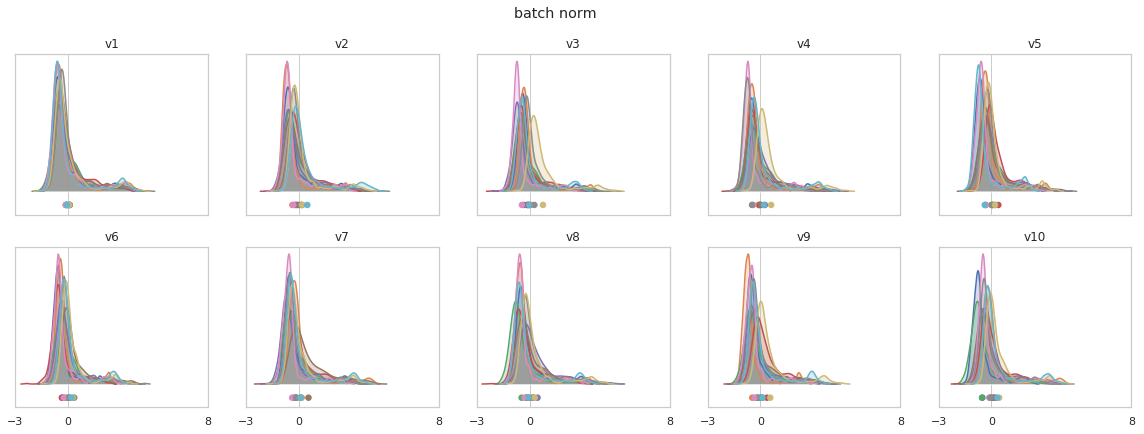

In [0]:
name = 'batch norm'
layout(np.array(list(fig[name].values())[:10]).reshape(2,5), sharex=True, xlim=(-3,8), vline_height=None, figure_title=name);

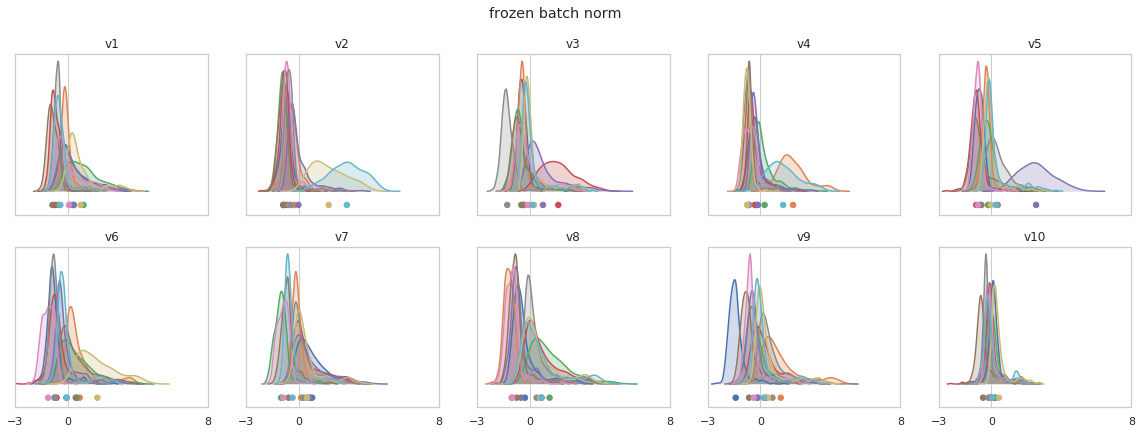

In [0]:
name = 'frozen batch norm'
layout(np.array(list(fig[name].values())[:10]).reshape(2,5), sharex=True, xlim=(-3,8), vline_height=None, figure_title=name);

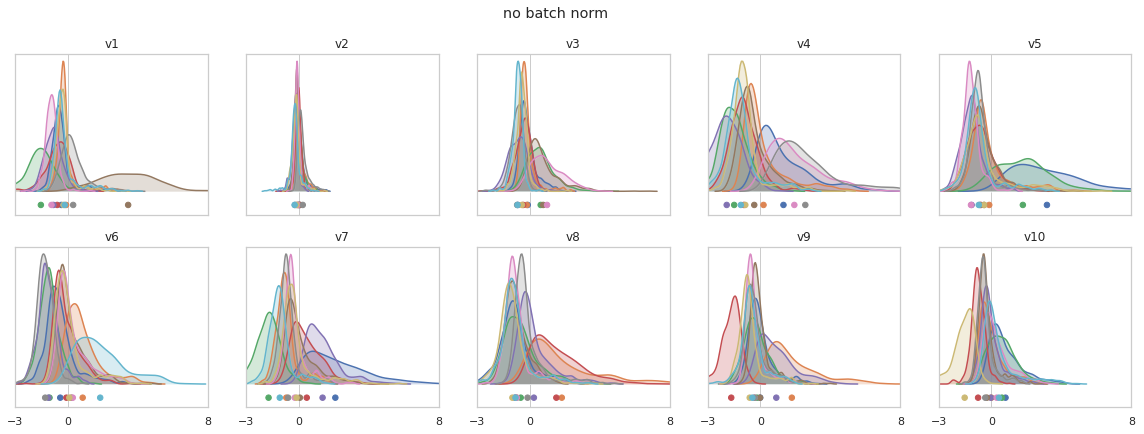

In [0]:
name = 'no batch norm'
layout(np.array(list(fig[name].values())[:10]).reshape(2,5), sharex=True, xlim=(-3,8), vline_height=None, figure_title=name);

对于“batch norm’”模型，不同渠道的均值受到一定的影响，但影响较轻。

For the 'batch norm' model , the means of different channels are somewhat affected but the effects are rather mild as expected. 

对于“冻结的batch norm”模型，出现了一个清晰的图像，其中，通常少数通道的均值受到来自v1-v9的每个特征向量的影响，而v10似乎主要对应于输出的重新缩放。

For the 'frozen batch norm' model,  a clear picture emerges in which the means of typically a small number of channels are affected by each eigenvector from v1-v9, whilst v10 appears to correspond primarily to a rescaling of the outputs. 

For the 'no batch norm' model, the 10 eigenvectors seem to correspond to a mixture of mean perturbations and rescalings of the different channels.
对于“无batch norm”模型，这10个特征向量似乎对应于不同通道的均值扰动和重新缩放的混合。


How can we make this analysis more precise?

我们如何把这个分析变得更加精准一些？


We have in hand the 10 vectors corresponding to gradients of the mean of each output channel. With these, we can compute the 10 dimensional subspace that they span and measure how much (of the norm squared) of a given eigenvector lies in this subspace. Note that a random vector of the same dimension (> 4 million) would have, with high probability, a norm squared component in a given 10 dimensional subspace of less than $10^{-5}$. 


我们手头有10个向量对应于每个输出通道均值的梯度。有了这些，我们可以计算它们张成的10维子空间并测量给定特征向量的范数平方在这个子空间中占多少。请注意，相同维数的随机向量(> 400万)在给定的10维子空间中有一个小于10−5的模平方分量，并且具有很高的概率。



Actually, shifting all of the output means in parallel has no effect on the loss, since the class proabilities are computed by applying a softmax function which is invariant under such an overall shift. As a result the relevant subspace of channel mean gradients which affect the loss is 9, not 10, dimensional. The loss has an exactly flat direction with coresponding zero eigenvalue of the Hessian in the direction of the overall shift. From now on we will describe the subspace of channel mean gradients as 9 dimensional, although the code below works with the full 10 dimensional space for simplicity.


实际上，并行移动所有输出意味着不会对损失产生影响，因为类的概率是通过应用softmax函数来计算的，而softmax函数在这样的整体移位下是不变的。因此，影响损失的通道平均梯度的相关子空间为9维，而不是10维。损失的方向恰好是平坦的，而Hessian的特征值在总位移方向上对应为零。从现在开始，我们将把通道平均梯度的子空间描述为9维，尽管为了简单起见，下面的代码使用完整的10维空间。

我们来计算特征向量和9维子空间之间的范数平方的重叠部分：实际上，并行移动所有输出意味着不会对损失产生影响，因为类的概率是通过应用softmax函数来计算的，而softmax函数在这样的整体移位下是不变的。因此，影响损失的通道平均梯度的相关子空间为9维，而不是10维。损失的方向恰好是平坦的，而Hessian的特征值在总位移方向上对应为零。从现在开始，我们将把通道平均梯度的子空间描述为9维，尽管为了简单起见，下面的代码使用完整的10维空间。

我们来计算特征向量和9维子空间之间的范数平方的重叠部分：

Let's compute the norm squared overlaps between the eigenvectors and our 9 dimensional subspace:

In [13]:
import scipy.linalg

def orthogonal_subspace(vecs):
  Q, R = scipy.linalg.qr(np.array(vecs).T, mode='economic')
  return Q.T

norm_sq_overlap = lambda vec, subspace: np.linalg.norm([np.dot(x, vec) for x in subspace])**2

subspaces = {name: orthogonal_subspace(grads) for name, grads in channel_mean_grads.items()}
overlaps = {name: [norm_sq_overlap(v, subspaces[name]) for v in vs] for name, (_, vs) in eigens.items()}
data = pd.DataFrame({'model': name, 'eigenvector index': i, 'norm sq overlap': x} for name, xs in overlaps.items() for i,x in enumerate(xs))
alt.Chart(data).mark_bar().encode(x='eigenvector index', y='norm sq overlap', column='model')

Chart({
  data:     eigenvector index              model  norm sq overlap
  0                   0         batch norm         0.025875
  1                   1         batch norm         0.137231
  2                   2         batch norm         0.144028
  3                   3         batch norm         0.495827
  4                   4         batch norm         0.562604
  5                   5         batch norm         0.604449
  6                   6         batch norm         0.524842
  7                   7         batch norm         0.485580
  8                   8         batch norm         0.246418
  9                   9         batch norm         0.333008
  10                 10         batch norm         0.217436
  11                 11         batch norm         0.470084
  12                 12         batch norm         0.376781
  13                 13         batch norm         0.484235
  14                 14         batch norm         0.105446
  15                 15         batch norm         0.051300
  16                 16         batch norm         0.054371
  17                 17         batch norm         0.024943
  18                 18         batch norm         0.025943
  19                 19         batch norm         0.081627
  20                 20         batch norm         0.053836
  21                 21         batch norm         0.067106
  22                 22         batch norm         0.032525
  23                 23         batch norm         0.075045
  24                 24         batch norm         0.000029
  25                  0  frozen batch norm         0.824599
  26                  1  frozen batch norm         0.830206
  27                  2  frozen batch norm         0.863597
  28                  3  frozen batch norm         0.795933
  29                  4  frozen batch norm         0.816881
  ..                ...                ...              ...
  45                 20  frozen batch norm         0.024996
  46                 21  frozen batch norm         0.013733
  47                 22  frozen batch norm         0.019705
  48                 23  frozen batch norm         0.004198
  49                 24  frozen batch norm         0.006696
  50                  0      no batch norm         0.354462
  51                  1      no batch norm         0.758231
  52                  2      no batch norm         0.594103
  53                  3      no batch norm         0.705404
  54                  4      no batch norm         0.534853
  55                  5      no batch norm         0.565737
  56                  6      no batch norm         0.763307
  57                  7      no batch norm         0.528678
  58                  8      no batch norm         0.780045
  59                  9      no batch norm         0.712027
  60                 10      no batch norm         0.696149
  61                 11      no batch norm         0.115893
  62                 12      no batch norm         0.091324
  63                 13      no batch norm         0.100177
  64                 14      no batch norm         0.074554
  65                 15      no batch norm         0.025380
  66                 16      no batch norm         0.043138
  67                 17      no batch norm         0.014259
  68                 18      no batch norm         0.046798
  69                 19      no batch norm         0.023942
  70                 20      no batch norm         0.056104
  71                 21      no batch norm         0.050881
  72                 22      no batch norm         0.037616
  73                 23      no batch norm         0.047033
  74                 24      no batch norm         0.016718
  
  [75 rows x 3 columns],
  encoding: FacetedEncoding({
    column: Column({
      field: 'model',
      type: 'nominal'
    }),
    x: X({
      field: 'eigenvector index',
      type: 'quantitative'
    }),
    y: Y({
      field: 'norm sq overlap',
      type: 

看到了吧，这并不是巧合！


Wow!! These are not random chance!


对于“冻结的batch norm”模型，我们立即对9个独立特征向量有了清晰的理解。这些几乎完全位于输出通道均值梯度的9维子空间中。我们的结论是，对于这个模型，SGD的主要不稳定性仅仅是由于无法控制输出的均值造成的。


For the 'frozen batch norm' model we arrive immediately at a clear understanding of the 9 outlying eigenvectors. These lie almost entirely in the 9 dimensional subspace of gradients of output channel means. We conclude that for this model, the leading instability of SGD is caused simply by a failure to control the means of the outputs.

我们能更好地解释其他模型的主要特征向量的更大比例吗？



Can we do better and explain an even greater fraction of the leading eigenvectors for the other models? 


在前面的图中可以看出，这些特征向量也影响输出方差。一个合理的想法是将我们的9维子空间扩展到19维，包括10个输出通道方差的梯度，甚至包括29维，包括输出通道的3阶矩或“倾斜”。重新缩放输出通道是另一种有效地破坏所有训练示例损失的方法，而且由于输出分布高度倾斜——为了让它们能够自信地预测给定的类——改变倾斜也可能产生影响。


A clue is in the previous plots showing that these eigenvectors also affect ouput variances. A reasonable idea would be to extend our 9 dimensional subspace to 19 dimensions by including gradients of the 10 output channel variances, or even to 29 dimensions to include 3rd moments or 'skews' of the output channels. Rescaling an output channel is another way to effectively damage the loss across all training examples and since the output distributions are highly skewed - to allow them to confidently predict a given class - changing the skews is also likely to have an effect. 



让我们使用上面机制来测试一下。首先计算各模型输出通道的方差和倾斜的梯度，
Let's use the machinery developed above to test this out. First we compute gradients of the variance and skew of the output channels of each model:

In [14]:
channel_vars = lambda model, batch: model(batch)['classifier_out'].var(0)

def channel_skews(model, batch):
    logits = model(batch)['classifier_out']
    mean = logits.mean(0, keepdim=True)
    return ((logits-mean)**3).mean(0)

channel_var_grads, channel_skew_grads = {}, {}

channel_grads = {name: {'means': grads} for name, grads in channel_mean_grads.items()}

for name, model in models.items():
  print(name)
  channel_grads[name]['vars'] = [to_numpy(compute_grad(model, fixed_train_batches, channel_vars, vec)) for vec in basis(10)]
  channel_grads[name]['skews'] = [to_numpy(compute_grad(model, fixed_train_batches, channel_skews, vec)) for vec in basis(10)]

batch norm
frozen batch norm
no batch norm


Then we compute the norm squared overlaps between eigenvectors and subspaces:

然后计算特征向量与子空间之间的范数平方的重叠：

In [15]:
subspaces = {name: orthogonal_subspace(np.vstack([np.array(g) for g in grads.values()])) for name, grads in channel_grads.items()}
subspace_groups = {name: {'means': subspace[0:10], 'vars': subspace[10:20], 'skews': subspace[20:30]} for name, subspace in subspaces.items()}

data = pd.DataFrame({'model': name, 'eigenvector index': i, 'norm sq overlap': norm_sq_overlap(v, subspace), 'subspace': f'channel {moment}', 'sort index': j} for name, subspaces in subspace_groups.items()
                    for j,(moment, subspace) in enumerate(subspaces.items()) for i,v in enumerate(eigens[name][1]))
                    
alt.Chart(data).mark_bar().encode(x='eigenvector index', y=alt.Y('sum(norm sq overlap)', sort=None), color=alt.Color('subspace', sort=None), order=alt.Order('sort index', sort='ascending'), column='model')                    

Chart({
  data:      eigenvector index          model  norm sq overlap  sort index  \
  0                    0     batch norm         0.025875           0   
  1                    1     batch norm         0.137231           0   
  2                    2     batch norm         0.144028           0   
  3                    3     batch norm         0.495827           0   
  4                    4     batch norm         0.562605           0   
  5                    5     batch norm         0.604451           0   
  6                    6     batch norm         0.524843           0   
  7                    7     batch norm         0.485584           0   
  8                    8     batch norm         0.246419           0   
  9                    9     batch norm         0.333008           0   
  10                  10     batch norm         0.217437           0   
  11                  11     batch norm         0.470086           0   
  12                  12     batch norm         0.376782           0   
  13                  13     batch norm         0.484236           0   
  14                  14     batch norm         0.105446           0   
  15                  15     batch norm         0.051300           0   
  16                  16     batch norm         0.054371           0   
  17                  17     batch norm         0.024943           0   
  18                  18     batch norm         0.025943           0   
  19                  19     batch norm         0.081628           0   
  20                  20     batch norm         0.053836           0   
  21                  21     batch norm         0.067106           0   
  22                  22     batch norm         0.032525           0   
  23                  23     batch norm         0.075045           0   
  24                  24     batch norm         0.000029           0   
  25                   0     batch norm         0.045987           1   
  26                   1     batch norm         0.488985           1   
  27                   2     batch norm         0.244741           1   
  28                   3     batch norm         0.331611           1   
  29                   4     batch norm         0.315262           1   
  ..                 ...            ...              ...         ...   
  195                 20  no batch norm         0.104184           1   
  196                 21  no batch norm         0.073684           1   
  197                 22  no batch norm         0.106761           1   
  198                 23  no batch norm         0.103117           1   
  199                 24  no batch norm         0.044504           1   
  200                  0  no batch norm         0.036435           2   
  201                  1  no batch norm         0.055411           2   
  202                  2  no batch norm         0.064603           2   
  203                  3  no batch norm         0.061321           2   
  204                  4  no batch norm         0.035404           2   
  205                  5  no batch norm         0.095321           2   
  206                  6  no batch norm         0.019790           2   
  207                  7  no batch norm         0.075548           2   
  208                  8  no batch norm         0.017616           2   
  209                  9  no batch norm         0.056424           2   
  210                 10  no batch norm         0.034500           2   
  211                 11  no batch norm         0.224316           2   
  212                 12  no batch norm         0.308051           2   
  213                 13  no batch norm         0.238526           2   
  214                 14  no batch norm         0.330011           2   
  215                 15  no batch norm         0.202787           2   
  216                 16  no batch norm         0.241163           2   
  217                 17  no batch norm         0.229526           2   
  218                 18  

结果更加明显！

我们已经证明，“冻结的batch norm”模型的前10个特征向量几乎完全位于完整的> 400万维参数空间的29维子空间(由每个类输出分布的前三个矩的梯度张成)的可解释范围内。对于“无batch norm”模型，甚至对于“batch norm”模型，结果几乎同样惊人。

最后一点可能看起来很奇怪，但是回想一下，对于batch norm模型，主特征值要小得多。下面我们通过对应的特征值重新调整了bar。我们可以看到，即使我们从输出的前三个时刻确定了不稳定性，没有激活的batch norm的两个模型仍然比batch norm模型稳定得多。

The results are even more striking! 

We have shown that the leading 10 eigenvectors of the 'frozen batch norm' model lie almost entirely inside an interpretable (spanned by gradients of the first three moments of the per class output distributions) 29 dimensional subspace of the full > 4 million dimensional parameter space.  The results are almost as striking for the 'no batch norm' model and even for the 'batch norm' model. 

This last point may seem suprising, but recall that the leading eigenvalues are much smaller for the batch norm model. Below we rescale the bars
by the corresponding eigenvalues. We see that even if we fixed the instability from the first three moments of the output, the two models without active batch norm would remain substantially less stable than the batch norm model. 

In [16]:
totals = data.groupby(['model','eigenvector index']).sum()['norm sq overlap']
others = pd.DataFrame([{'model': name, 'eigenvector index': i, 'norm sq overlap': 1.-total, 'subspace': 'other', 'sort index': 3} for name in models for i,total in enumerate(totals[name])])
scaled_data = pd.concat([data, others])
scaled_data['scaled overlap'] = [eigens[name][0][idx]*val for (idx, name, val) in zip(scaled_data['eigenvector index'], scaled_data['model'], scaled_data['norm sq overlap'])] 

alt.Chart(scaled_data).mark_bar().encode(x='eigenvector index', y=alt.Y('sum(scaled overlap)', sort=None), color=alt.Color('subspace', sort=None), order=alt.Order('sort index', sort='ascending'), column='model')                    

Chart({
  data:     eigenvector index              model  norm sq overlap  sort index  \
  0                   0         batch norm         0.025875           0   
  1                   1         batch norm         0.137231           0   
  2                   2         batch norm         0.144028           0   
  3                   3         batch norm         0.495827           0   
  4                   4         batch norm         0.562605           0   
  5                   5         batch norm         0.604451           0   
  6                   6         batch norm         0.524843           0   
  7                   7         batch norm         0.485584           0   
  8                   8         batch norm         0.246419           0   
  9                   9         batch norm         0.333008           0   
  10                 10         batch norm         0.217437           0   
  11                 11         batch norm         0.470086           0   
  12                 12         batch norm         0.376782           0   
  13                 13         batch norm         0.484236           0   
  14                 14         batch norm         0.105446           0   
  15                 15         batch norm         0.051300           0   
  16                 16         batch norm         0.054371           0   
  17                 17         batch norm         0.024943           0   
  18                 18         batch norm         0.025943           0   
  19                 19         batch norm         0.081628           0   
  20                 20         batch norm         0.053836           0   
  21                 21         batch norm         0.067106           0   
  22                 22         batch norm         0.032525           0   
  23                 23         batch norm         0.075045           0   
  24                 24         batch norm         0.000029           0   
  25                  0         batch norm         0.045987           1   
  26                  1         batch norm         0.488985           1   
  27                  2         batch norm         0.244741           1   
  28                  3         batch norm         0.331611           1   
  29                  4         batch norm         0.315262           1   
  ..                ...                ...              ...         ...   
  45                 20  frozen batch norm         0.760037           3   
  46                 21  frozen batch norm         0.827704           3   
  47                 22  frozen batch norm         0.782450           3   
  48                 23  frozen batch norm         0.920205           3   
  49                 24  frozen batch norm         0.899799           3   
  50                  0      no batch norm         0.047921           3   
  51                  1      no batch norm         0.037847           3   
  52                  2      no batch norm         0.036209           3   
  53                  3      no batch norm         0.034305           3   
  54                  4      no batch norm         0.119345           3   
  55                  5      no batch norm         0.143236           3   
  56                  6      no batch norm         0.052814           3   
  57                  7      no batch norm         0.181322           3   
  58                  8      no batch norm         0.052359           3   
  59                  9      no batch norm         0.059076           3   
  60                 10      no batch norm         0.201367           3   
  61                 11      no batch norm         0.615159           3   
  62                 12      no batch norm         0.562744           3   
  63                 13      no batch norm         0.586456           3   
  64                 14      no batch norm         0.575085           3   
  65                 15      no batch norm         0.695411           3   
  66       

更精确的方法是重新计算被限制在与三个输出力矩的梯度的29维子空间正交的子空间上的Hessian矩阵的主导特征值：

A more precise way to see this is to recompute the leading eigenvalues of the Hessian restricted to the subspace orthogonal to the 29 dimensional subspace of gradients of the three output moments:

In [18]:
project_orthogonal_to = lambda vec, subspace: vec - (subspace @ vec) @ subspace

eigens_proj = {}
for name, model in models.items():
  print(name)
  model = models[name]
  op = HvOperator(model, fixed_train_batches[:num_batches], projection=partial(project_orthogonal_to, subspace=subspaces[name]))
  eigens_proj[name] = compute_top_k_eigens(op, k=25)

batch norm
   iteration         time   total time
          10      12.3445     124.2338
          20      12.4371     248.2065
          30      12.4476     372.6009
          40      12.4754     497.1650
          50      12.5129     622.3747
          60      12.4924     748.9257
          70      12.4340     875.7104
          80      14.0781    1002.6804
          90      12.5328    1127.7853
         100      12.5024    1254.5945
frozen batch norm
   iteration         time   total time
          10       9.8768      99.3891
          20       9.8935     198.3858
          30       9.9658     297.6334
          40       9.9784     397.3590
          50      10.0066     497.5400
          60       9.9988     599.2021
          70      10.0210     701.0043
          80       9.8896     802.4275
          90       9.9071     902.2530
         100      10.0442    1003.6445
         110       9.9245    1105.1047
no batch norm
   iteration         time   total time
          10       8.

In [20]:
data = [{'e-value': λ, 'model': name, 'projected': False} for name, (λs, _) in eigens.items() for λ in λs]
data += [{'e-value': λ, 'model': name, 'projected': True} for name, (λs, _) in eigens_proj.items() for λ in λs]

alt.Chart(pd.DataFrame(data)).mark_circle().encode(x='e-value', y='model', color='model', row='projected')

Chart({
  data:          e-value              model  projected
  0     127.874138         batch norm      False
  1     105.467880         batch norm      False
  2      97.001770         batch norm      False
  3      93.973862         batch norm      False
  4      92.090591         batch norm      False
  5      88.133598         batch norm      False
  6      85.399956         batch norm      False
  7      84.064194         batch norm      False
  8      83.532356         batch norm      False
  9      82.101646         batch norm      False
  10     81.264442         batch norm      False
  11     77.924858         batch norm      False
  12     76.747070         batch norm      False
  13     74.814804         batch norm      False
  14     70.534538         batch norm      False
  15     60.563454         batch norm      False
  16     58.530533         batch norm      False
  17     57.215748         batch norm      False
  18     53.429234         batch norm      False
  19     51.783249         batch norm      False
  20     49.568657         batch norm      False
  21     47.655037         batch norm      False
  22     46.404064         batch norm      False
  23     45.259327         batch norm      False
  24    -46.415844         batch norm      False
  25   2245.977539  frozen batch norm      False
  26   2079.373535  frozen batch norm      False
  27   1804.956421  frozen batch norm      False
  28   1588.736328  frozen batch norm      False
  29   1504.795898  frozen batch norm      False
  ..           ...                ...        ...
  120    97.794128  frozen batch norm       True
  121    95.133461  frozen batch norm       True
  122    93.816414  frozen batch norm       True
  123    92.416321  frozen batch norm       True
  124   -93.638672  frozen batch norm       True
  125  1324.065430      no batch norm       True
  126   817.417053      no batch norm       True
  127   655.256104      no batch norm       True
  128   541.873230      no batch norm       True
  129   520.294006      no batch norm       True
  130   463.217957      no batch norm       True
  131   425.980560      no batch norm       True
  132   404.006287      no batch norm       True
  133   375.833252      no batch norm       True
  134   359.294922      no batch norm       True
  135   339.573242      no batch norm       True
  136   313.497894      no batch norm       True
  137   306.930908      no batch norm       True
  138   294.462067      no batch norm       True
  139   274.544403      no batch norm       True
  140   269.027191      no batch norm       True
  141   267.357513      no batch norm       True
  142   250.439453      no batch norm       True
  143   247.870926      no batch norm       True
  144   234.537109      no batch norm       True
  145   231.407013      no batch norm       True
  146   228.092422      no batch norm       True
  147   217.029633      no batch norm       True
  148   212.127563      no batch norm       True
  149   203.915176      no batch norm       True
  
  [150 rows x 3 columns],
  encoding: FacetedEncoding({
    color: Color({
      field: 'model',
      type: 'nominal'
    }),
    row: Row({
      field: 'projected',
      type: 'nominal'
    }),
    x: X({
      field: 'e-value',
      type: 'quantitative'
    }),
    y: Y({
      field: 'model',
      type: 'nominal'
    })
  }),
  mark: 'circle'
})

We see that the 'no batch norm' and 'frozen batch norm' models are substantially more stable than before, but there is still work to do before they reach the stability of the 'batch norm' model. We discsuss this below.

我们发现，“无batch norm”和“冻结的batch norm”模型比以前稳定了很多，但是在它们达到“batch norm”模型的稳定性之前，还有很多工作要做。我们在下面讨论这个问题。

## Discussion

讨论
我们学到了点什么？

首先，我们回顾了结果，在没有batch norm的情况下，具有标准初始化的深度网络往往会产生“坏的”，几乎是常数的输出分布，其中的输入被忽略。我们讨论了batch norm是如何防止这种情况发生的，并且可以通过使用“冻结”batch norm在初始化时修复这种情况。



So what have we learned? 

First we reviewed the result that, in the absence of batch norm, deep networks with standard initialisations tend to produce 'bad', almost constant output distributions in which the inputs are ignored. We discussed how batch norm prevents this and that this can also be fixed at initialisation by using 'frozen' batch norm.

接下来，我们转向训练，并展示了“坏”配置存在于典型训练运行期间遍历的参数配置附近。通过计算每个通道输出分布平均值的梯度，我们明确地发现了这样的邻近配置。稍后，我们通过计算每个通道输出分布的方差和倾斜的梯度来扩展这一点，我们认为改变这些高阶统计量也会导致损失的大量增加。我们解释了batch norm如何通过防止对内部层分布统计信息的更改传播，从而大大降低这些方向上的梯度。



Next we turned to training and showed that 'bad' configurations exist near to the parameter configurations traversed during a typical training run. We explicitly found such nearby configurations by computing gradients of the means of the per channel output distributions. Later we extended this by computing gradients of the variance and skew of the per channel output distributions, arguing that changing these higher order statistics would also lead to a large increase in loss. We explained how batch norm, by preventing the propagation of changes to the statistics of internal layer distributions, greatly reduces the gradients in these directions.

最后，我们研究了导致SGD失稳的主要特征值和损失Hessian特征向量，并证明了主要特征向量主要位于我们之前计算的输出统计量梯度的低维子空间。对这一事实的解释是，不稳定的“原因”实际上是由于未能对输出分布的矩施加适当的约束而产生的高度弯曲的损失情况。



Finally, we investigated the leading eigenvalues and eigenvectors of the Hessian of the loss, which account for the instability of SGD, and showed that the leading eigenvectors lie primarily in the low dimensional subspaces of gradients of output statistics that we computed before. The interpretation of this fact is that the _cause_ of instability is indeed the highly curved loss landscape that is produced by failing to enforce appropriate constraints on the moments of the output distribution.

退后一步，我们得到的最主要的教训是深度网络提供了一个方便的参数化的非常大不同类别的函数，能表达许多感兴趣的计算，但在这个参数化有一定的约束，需要产生有用的函数，而不是常量。在训练过程中，必须保持这些约束，这给SGD这样的一阶优化器带来了沉重的负担，SGD的学习率受到正交于“好”子空间方向的陡峭曲率的限制。



Taking a step back, the main lesson is that deep nets provide a convenient parameterisation of a large class of functions, capable of expressing many computations of interest, but that within this parameterisation there are certain constraints that need to be observed to produce useful functions - rather than say constants. During training, it is necessary to maintain these constraints and this places a heavy burden on a first-order optimiser such as SGD, whose learning rate is limited by the steep curvature in the directions orthogonal to the 'good' subspace. 

一个可能的解决方案是使用二阶优化器来处理有问题的曲率。(事实上，我们的研究结果为使用所谓的“广义高斯-牛顿”近似于Hessian定理的二阶方法的成功提供了一些线索，因为我们确定的孤立特征值来自于这一项。)然而，上述结果可能会让人相信，与一阶优化器相结合的batch norm(通过改进函数空间的参数化，直接解决存在问题的曲率背后的问题)等方法将很难被击败。


A possible solution would be to use a second-order optimiser to handle the problematic curvature. (Indeed, our results cast some light on the success of second-order methods using the so-called 'generalised Gauss-Newton' approximation to the Hessian, since the outlying eigenvalues that we identify originate within this term.) However, the results above might convince one that a method such as batch normalisation - which directly tackles the issue underlying the problematic curvature by improving the parameterisation of function space - coupled with a first-order optimiser, is going to be hard to beat. 


尽管我们关注的是输出层中通道的分布，但是仅仅解决这些问题是不够的。如果是的话，我们可以在网络的末端放置一个单独的batch norm层，这可以和分布在整个网络中的batch norm一样有效。上面的最后一个图显示了在固定输出分布的前几个矩之后剩余的不稳定性的大小，表明这样做不太可能接近网络的稳定状态，因为整个网络中都有batch norm层。



Despite our focus on the distributions of channels in the output layer, it is not sufficient to fix these. If it were, we could place a single batch norm layer towards the end of the network and this could be expected to work as well as batch norms distributed throughout. The final plot above - which shows the scale of residual instabilities after fixing the leading moments of the output distributions - indicates that doing so is unlikely to approach the stability of the network with batch norm layers throughout. 

一个合理的预期是，为了保持由网络计算的函数的表达性，内部层分布也很重要。例如，如果在某个中间层，少数通道占主导地位，就会带来瓶颈，从而大大减少了网络能够表示的函数集。我们期望直接处理这种“内部”分配的转移是batch norm的进一步作用，这是未来研究的一个有趣方向。



A reasonable expectation is that the internal layer distributions are also important in order to maintain the expressivity of the function computed by the network. For example, if at some intermediate layer, a small number of channels become dominant, this would introduce a bottleneck, greatly reducing the set of functions that the network is capable of representing. We would expect that directly tackling this kind of _internal_ distributional shift is a further role of batch norm and this is an interesting direction for future research.

另一个教训是，batch norm似乎几乎是为解决关键优化问题而设计的，而优化问题实际上是传播对信道分布的更改。研究已经提出的batch norm的各种替代方案，了解它们是否以及如何实现类似的功能，将是非常有趣的。这些见解还应在开发新的稳定机制方面提供指导，潜在地提供一个比另一种观望的方法更为敏锐的工具。



Another lesson is that batch norm seems almost ideally designed to tackle the key optimisation issue, which is indeed one of propagation of changes to channel-wise distributions. It would be very interesting to investigate the various alternatives to batch norm that have been proposed and understand if and how they manage to achieve a similar thing. These insights should also provide guidance in developing new stabilisation mechanisms, potentially providing a sharper toolkit than the alternative run-it-and-see approach.



在结束之前，我想总结一些“元”经验。首先，可视化很重要！这个项目被卡住的时间比我想起来的要长，直到我终于咬紧咬住了重点，开发了贯穿全文的通道直方图。有了这些，就有可能可视化Hessian的特征向量，并对实际发生的事情发展出一种直觉。


Before closing, there are a couple of 'meta'-lessons I'd like to draw. The first is that visualisation is important! This project was stuck for longer than I care to recall until I finally bit the bullet and developed the channel-wise histogram plots that appear throughout the post. With these in hand, it became possible to visualise eigenvectors of the Hessian and develop an intuition for what was really going on. 


其次，这是一个关于函数空间的优化器和参数化的故事——它几乎与数据集无关！在ImageNet上运行这个函数不仅会大大降低速度，而且类的数量越多，在大量的数字噪音下，就会掩盖关键问题。我预测，在基础问题上的进展将继续使用小型模型和数据集。

Secondly, this is a story about optimisers and parameterisations of function spaces - it has almost nothing to do with datasets! Running this on ImageNet would not only have slowed things down massively, but the higher number of classes would have obscured the key issues under a mountain of numerical noise. I predict that progress on foundational issues will continue to be made using small models and datasets.

